Plot and save figures for the manuscript.

# Set up

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import pickle
import json
import os
import glob
from data_analysis.color4plot import color4plot
from data_analysis.yml2dict import yml2dict
from data_analysis.estimate_likelihood import rect_sin, mixed_sin
from data_analysis.evaluate_prior import simul_estimate, each_loglik
from scipy.signal import find_peaks
from scipy.stats import circmean, circstd

def rep_end(estimates):
    """
    Duplicate the first and the last stimuli for visualization.

    """
    first = estimates[estimates['Hue Angle'] == estimates['Hue Angle'].min()]
    first_copy = first.copy()
    first_copy['Hue Angle'] = first_copy['Hue Angle'].apply(lambda x: x + 360)

    last = estimates[estimates['Hue Angle'] == estimates['Hue Angle'].max()]
    last_copy = last.copy()
    last_copy['Hue Angle'] = last_copy['Hue Angle'].apply(lambda x: x - 360)

    estimates_plt = pd.concat([estimates, first_copy, last_copy], ignore_index=False).sort_values('Hue Angle')
    return estimates_plt

# Load PF estimates data
sel_sub = "s3"

all_pf_estm= pd.read_csv('data_analysis/pf_estimates/all_estimates.csv')
# Reverse PSE
all_pf_estm['PSE'] = - all_pf_estm['PSE']
all_pf_estim_4plot = all_pf_estm.groupby('subject').apply(lambda grp: rep_end(grp))

sAVG_pf_estm = pd.read_csv('data_analysis/pf_estimates/avg_estimates.csv')
sAVG_pf_estm['PSE'] = - sAVG_pf_estm['PSE']
sAVG_pf_estm_4plot = rep_end(sAVG_pf_estm)

# Load modeling parameter and prior estimates

model_path = "data_analysis/model_estimates_v2"

x_grid = np.load(f"{model_path}/x_grid.npy")

# btrp_priors = pd.read_csv(f"{model_path}/gauss_prior_btrp100.csv")
# mean_btrp_priors = pd.read_csv(f"{model_path}/gauss_prior_btrp100_mean.csv")

# sine_priors = pd.read_csv(f"{model_path}/sine_prior.csv")

def prior_uniform():
    y = 1./(len(x_grid))
    return np.repeat(y, len(x_grid))

# Set plot style
plt.style.use('data_analysis/figures/plot_style.txt')
fig_width = 7.2
hue_angles = np.arange(-22.5, 360+45, 45)
colorcode = yml2dict("data_analysis/rgb4plot.yaml")

x_major_ticks = np.array([0, 90, 180, 270, 360])
x_minor_ticks = np.linspace(0, 360, 8, endpoint=False)


cond_cfg = {'labels':
                    {'LL': 'L-L', 
                    'HH': 'H-H', 
                    'LH': 'L-H'},
            'linecolors':
                    {'LL': [.3, .3, .3],
                    'HH': [.7, .7, .7],
                    'LH': [.5, .5, .5]},
            'markers':
                    {'LL': 's',
                    'HH': 'v',
                    'LH': 'o'}}
                    
legend_loc = [0.68, 0.9]

# for non-filled markers
marker_size = 4     
marker_linewidth = 0.5 

fig_dir = "project_documents/manuscript/figures/"



# Pyschometric functions in Fig 1 (method illustration figure)

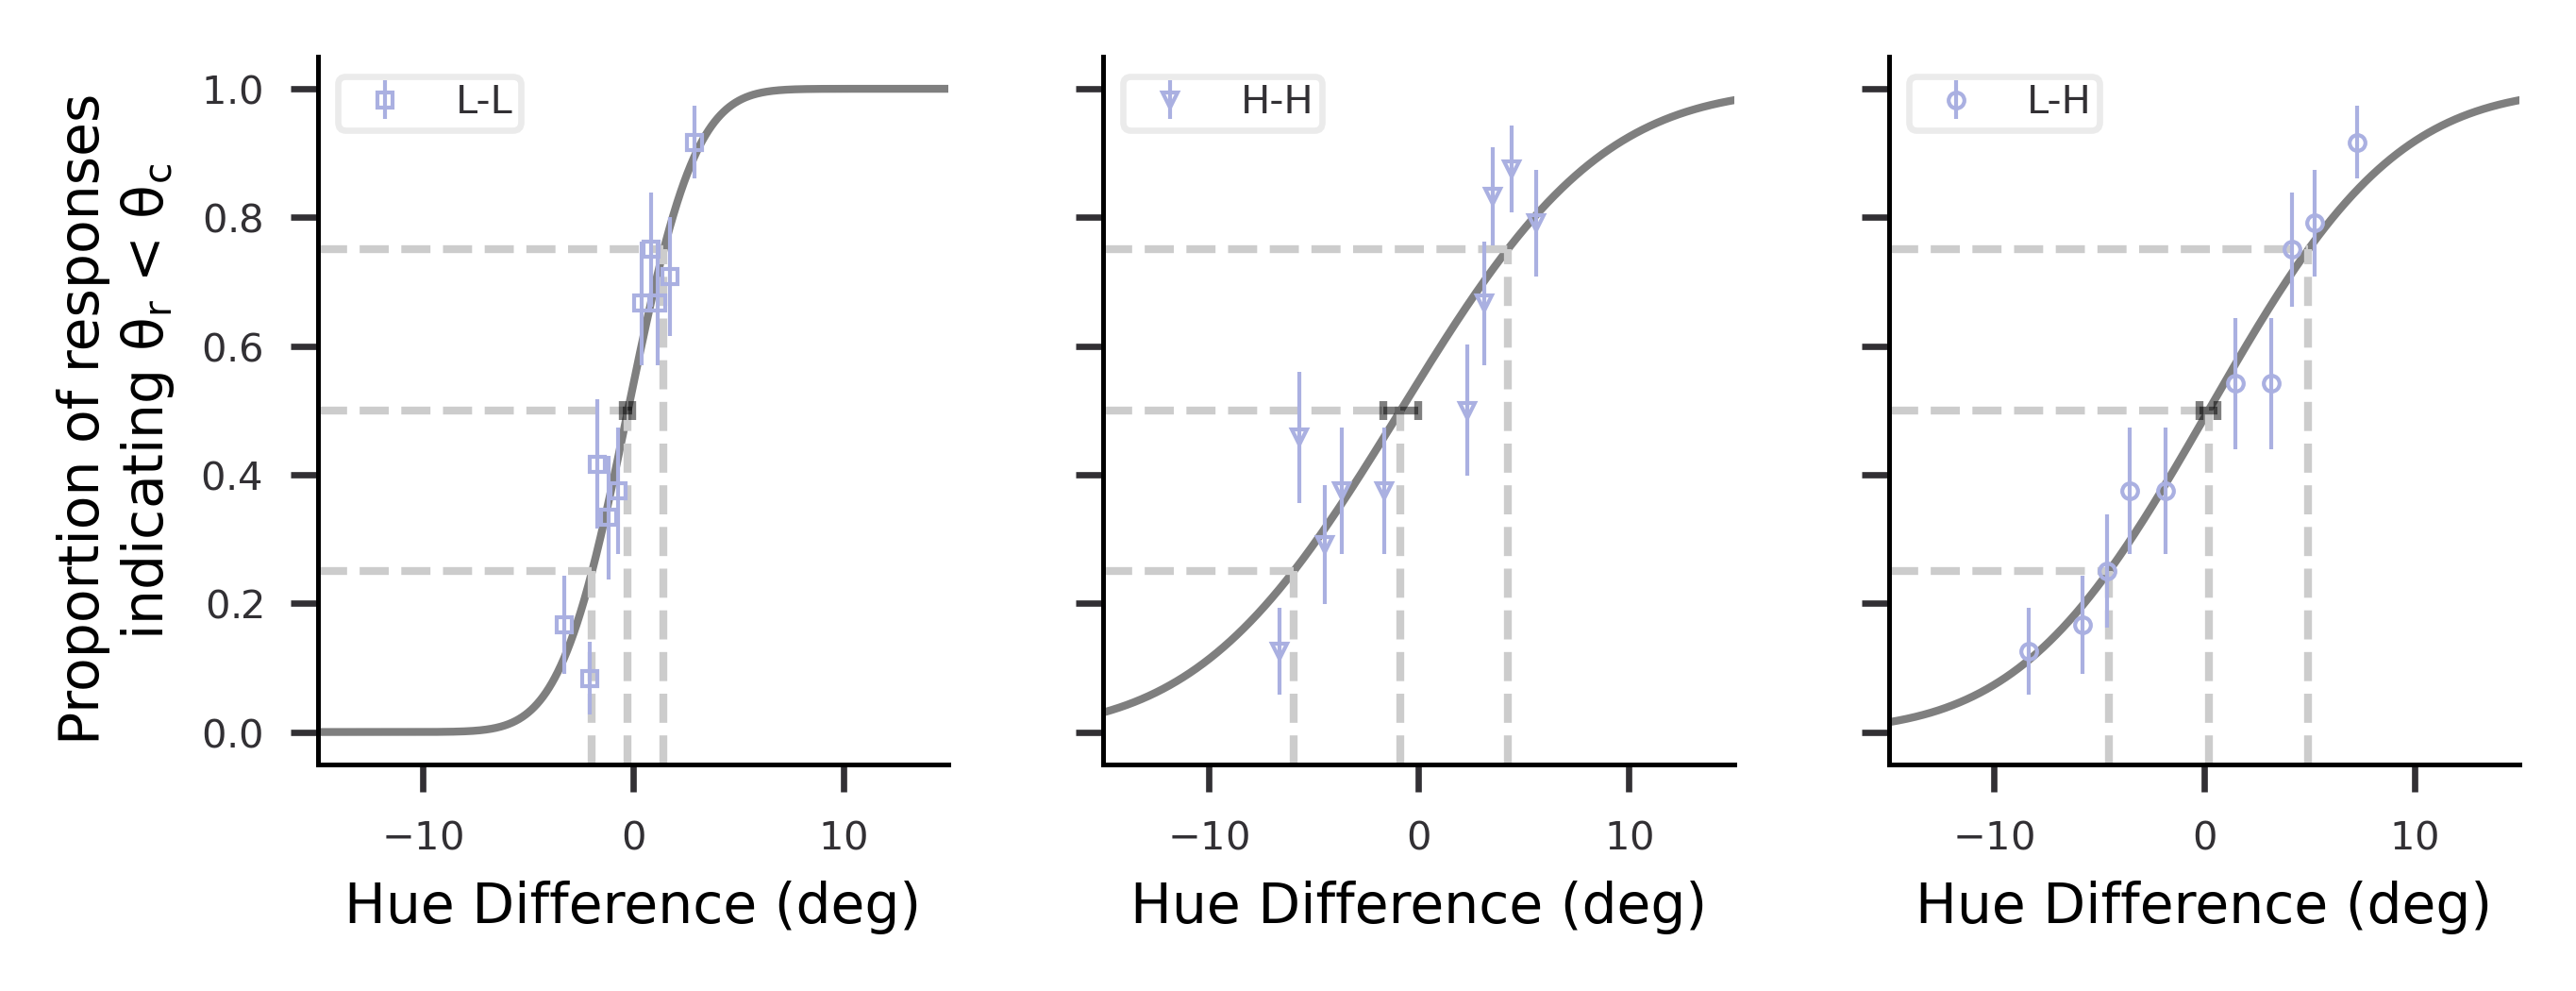

In [17]:
from data_analysis.fit_pf_nls import FitPf

dat = pd.read_csv('data/all_sel_data.csv')
sub_dat = dat[dat['subject']=='s03']
sAVG_ll, sAVG_hh, sAVG_lh = sub_dat.query("condition == 'LL'"), sub_dat.query("condition == 'HH'"), sub_dat.query("condition == 'LH'")

fit_ll = FitPf(sAVG_ll.query("standard_stim == 112.5"), bins=10).fit()  #bins=20 or 'unique'
fit_hh = FitPf(sAVG_hh.query("standard_stim == 112.5"), bins=10).fit()
fit_lh = FitPf(sAVG_lh.query("standard_stim == 112.5"), bins=10).fit()

"""
Plot PFs from nonlinear least squares fitting results.

"""


fit_dats = [fit_ll, fit_hh, fit_lh]
num = len(fit_dats)
# num = 1

subplot_width, subplot_height = 2.0, 2.0 


xlim = [-15, 15]
ylim = [-.05, 1.05]

fig, axes = plt.subplots(1, num, figsize=(subplot_width*num*.8, subplot_height), sharey=True)
# fig, axes = plt.subplots(1, 1, figsize=(subplot_width, subplot_height))

for idx, cond in zip(np.arange(len(fit_dats)), ['LL', 'HH', 'LH']):
    fit_dat = fit_dats[idx]
    for key in fit_dat:

        this_dat = fit_dat[key]
        this_fit = this_dat['fit']
        ntrial = this_dat['Trial N']

        if num == 1:
            ax = axes
        else:
            ax = axes.flatten()[idx]

        hue_angle = this_dat['Hue Angle']
        color = colorcode[hue_angle]

        # hue_angles = np.array([float(k) for k in fit_dat.keys()])
        # color = colorcodes[int((key - self.first_angle) / self.first_angle / 2)]
        # for inten, resp, se in zip(this_dat['Binned Intensities'],
        #                             this_dat['Binned Responses'],
        #                             this_dat['sems']):
            # ax.plot(inten, resp, '.', color=color, markersize=marker_size, zorder=3)  # marker=cond_cfg['markers']['LL'],
        intens = np.array(this_dat['Binned Intensities'])
        resp = np.array(this_dat['Binned Responses'])
        n_per_bin = np.array(this_dat['Binned N'])
        # ax.scatter(intens, resp, 
        #            marker=cond_cfg['markers'][cond], color=color, s=2.5, zorder=3, edgecolors='black', linewidths=.1, label=cond) 

        ax.errorbar(intens, resp, yerr=np.sqrt(resp * (1-resp)/n_per_bin), marker=cond_cfg['markers'][cond], 
                    elinewidth=.5, ecolor=color, linestyle="None", capsize=0, mfc='none', mec=color, mew=.5, ms=2., zorder=3, label=cond[0]+'-'+cond[1])

        # smoothResp = np.arange(0.0, 1.0, .02)
        # smoothInt = this_fit.inverse(smoothResp)
        smoothInt = np.arange(-15, 15, .02)
        smoothResp = this_fit.eval(smoothInt)
        ax.plot(smoothInt, smoothResp, '-', color='black', alpha=.5)  # plot fitted curve

        for val in [.25, .5, .75]:
            ax.hlines(y=val, xmin=xlim[0], xmax=this_fit.inverse(val), linestyles='dashed', colors=[.8, .8, .8])
            ax.vlines(x=this_fit.inverse(val), ymin=ylim[0], ymax=val, linestyles='dashed', colors=[.8, .8, .8])

        # plot errorbars
        thr_err = [this_dat['PSE']-this_dat['PSE_err'], this_dat['PSE']+this_dat['PSE_err']]
        ax.hlines(.5, thr_err[0], thr_err[1], color='black', alpha=.5)
        [ax.vlines(ci_x, .5-0.015, .5+0.015, color='black', alpha=.5) for ci_x in thr_err] 

        ssq = np.round(this_dat['ssq'], decimals=3)  # sum-squared error
        # ax.text(3.5, 0.55, 'ssq = ' + str(ssq))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.tick_params(axis='both', which='major')
        ax.legend()
        # if num == 1:
            # x_ax = ax
            # y_ax = ax
        # elif num == 2:
        #     x_ax = axes[-1]
        #     y_ax = axes[0]
        # else:
        #     x_ax = axes[-1, :]
        #     y_ax = axes[:, 0]

[plt.setp(ax, xlabel='Hue Difference (deg)') for ax in axes]
plt.setp(axes[0], ylabel='Proportion of responses \n indicating $\\theta_{r}$ < $\\theta_{c}$')

# plt.setp(ax.get_xticklabels())
# plt.setp(ax.get_yticklabels())
plt.tight_layout()

# plt.savefig(f"{fig_dir}Fig_0_err.pdf")
plt.show()

# Results 1

In [3]:
def behavioral_subplots(estimates, ylim=[[0, 15], [0, 15], [-10, 10]], fig_name=None):
    subs = estimates.subject.unique()
    n_sub = len(subs)
    
    marker_color = color4plot(hue_angles)

    capsize = 4
    alpha = {'line': 1., 'marker': 0.7}

    if n_sub == 2:
        subplot_width, subplot_height = 1.5, 1.5
    else:
        #  subplot_width, subplot_height = fig_width/n_sub, fig_width/n_sub
         subplot_width, subplot_height = 1.4, 1.4
    if n_sub == 2:
        fig, axes = plt.subplots(figsize=(subplot_width * n_sub, subplot_height * 3), nrows=3, ncols=n_sub, sharex='none', sharey='row')
    else:
        fig, axes = plt.subplots(figsize=(subplot_width * n_sub, subplot_height * 3), nrows=3, ncols=n_sub, sharex='none', sharey='row')
        
    for i_sub, sub in enumerate(subs):
        sub_estimate = estimates.query("subject == @sub")

        # Plot JND, same-noise
        for key, grp in sub_estimate.query("condition=='LL' or condition=='HH'").groupby('condition'):

            axes[0, i_sub].set_title(sub)
            axes[0, i_sub].errorbar(x=grp['Hue Angle'], y=grp['JND'], yerr=grp['JND_err'],
                                    c=cond_cfg['linecolors'][key], linestyle='dashed', capsize=capsize, zorder=2)
            axes[0, i_sub].scatter(x=grp['Hue Angle'], y=grp['JND'],
                                    c=marker_color, marker=cond_cfg['markers'][key], edgecolors='none', alpha=alpha['marker'],
                                    label=cond_cfg['labels'][key], zorder=3)
            axes[0, i_sub].set_yticks(np.arange(0, 30, step=5))
            # ax[0].set_yscale('log')
            # ax[0].set_ylim([10**(0), 10**1.5])
            axes[0, i_sub].set_ylim(ylim[0])  
            # if n_sub == 2:
            #     axes[0, i_sub].set_ylabel('JND (deg), same-noise')
            leg = axes[0, i_sub].legend(loc=legend_loc, frameon=False, handletextpad=0.05)
            [marker.set_color([.66, .66, .66]) for marker in leg.legendHandles]

        # Plot JND, cross-noise
        # [axes[1, i_sub].vlines(x, 0, 15, alpha=gridline['alpha'], colors=gridline['color'], linewidth=gridline['width'], zorder=1)
        #  for x in x_major_ticks]
        estimates_LH = sub_estimate.query("condition=='LH'")
        axes[1, i_sub].errorbar(x=estimates_LH['Hue Angle'], y=estimates_LH['JND'], yerr=estimates_LH['JND_err'],
                        c=cond_cfg['linecolors']['LH'], linestyle='dashed', capsize=capsize, zorder=2)
        axes[1, i_sub].scatter(x=estimates_LH['Hue Angle'], y=estimates_LH['JND'],
                        c=marker_color, marker=cond_cfg['markers']['LH'], edgecolors='none', alpha=alpha['marker'],
                        label='L-H', zorder=3)
        axes[1, i_sub].set_yticks(np.arange(0, 30, step=5))
        # ax[1].set_yscale('log')
        # ax[1].set_ylim([10**(-1), 10**1.5])
        axes[1, i_sub].set_ylim(ylim[1])
        # if n_sub == 2:
        #     axes[1, i_sub].set_ylabel('JND (deg), cross-noise')
        leg = axes[1, i_sub].legend(loc=legend_loc, frameon=False, handletextpad=0.05)
        [marker.set_color([.66, .66, .66]) for marker in leg.legendHandles]

        # Plot PSE, cross-noise
        # [axes[2, i_sub].vlines(x, -10, 10,  alpha=gridline['alpha'], colors=gridline['color'], linewidth=gridline['width'], zorder=1)
        #  for x in x_major_ticks]
        # axes[2, i_sub].set_title(sub)
        axes[2, i_sub].errorbar(x=estimates_LH['Hue Angle'], y=estimates_LH['PSE'], yerr=estimates_LH['PSE_err'],
                        c=cond_cfg['linecolors']['LH'], linestyle='dashed', capsize=capsize, zorder=2)
        axes[2, i_sub].scatter(x=estimates_LH['Hue Angle'], y=estimates_LH['PSE'],
                        c=marker_color, marker=cond_cfg['markers']['LH'], edgecolors='none', alpha=alpha['marker'],
                        label='L-H', zorder=3)

        axes[2, i_sub].hlines(0, 0, 360, alpha=alpha['marker'],  colors=[.8, .8, .8], linestyle='--', zorder=1)
        axes[2, i_sub].set_yticks(np.arange(-20, 20, step=5))
        axes[2, i_sub].set_ylim(ylim[2])   
        # if n_sub == 2:
        #     axes[2, i_sub].set_ylabel('PSE (deg), cross-noise')

        for i_row in range(3):
            axes[i_row, i_sub].set_xlim([0, 360])
            axes[i_row, i_sub].xaxis.set_minor_locator(plt.FixedLocator(x_minor_ticks))
            axes[i_row, i_sub].xaxis.set_major_locator(plt.FixedLocator(x_major_ticks))
            # plt.setp(axes[:, i_sub].xaxis.get_majorticklabels(), rotation=0)
            # axes[2, i_sub].set_xticks(x_ticks)
            # axes[2, i_sub].set_xticklabels(x_ticks, rotation=45)
            axes[i_row, i_sub].set_xlabel('Hue Angle (deg)')
        
        if n_sub >= 2:
            axes[0, 0].set_ylabel('JND (deg), same-noise')
            axes[1, 0].set_ylabel('JND (deg), cross-noise')
            axes[2, 0].set_ylabel('PSE (deg), cross-noise')


    plt.tight_layout()
    plt.show()
    
    if fig_name is not None:
        fig.savefig(fig_dir + fig_name +".pdf", bbox_inches='tight', dpi=600)
    

## Fig 2
Figure 2. Behavioral measurement estimates for a single subject (left) and the average subject (right). Top: hue discrimination thresholds (i.e. just noticeable differences, JNDs) under the same-noise condition. Middle: hue discrimination thresholds under the cross-noise condition. Bottom: Relative biases under the cross-noise condition, measured as hue angle differences between the high-noise stimulus and the low-noise stimulus at the PSE. Bars denote one standard error of the estimates.

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


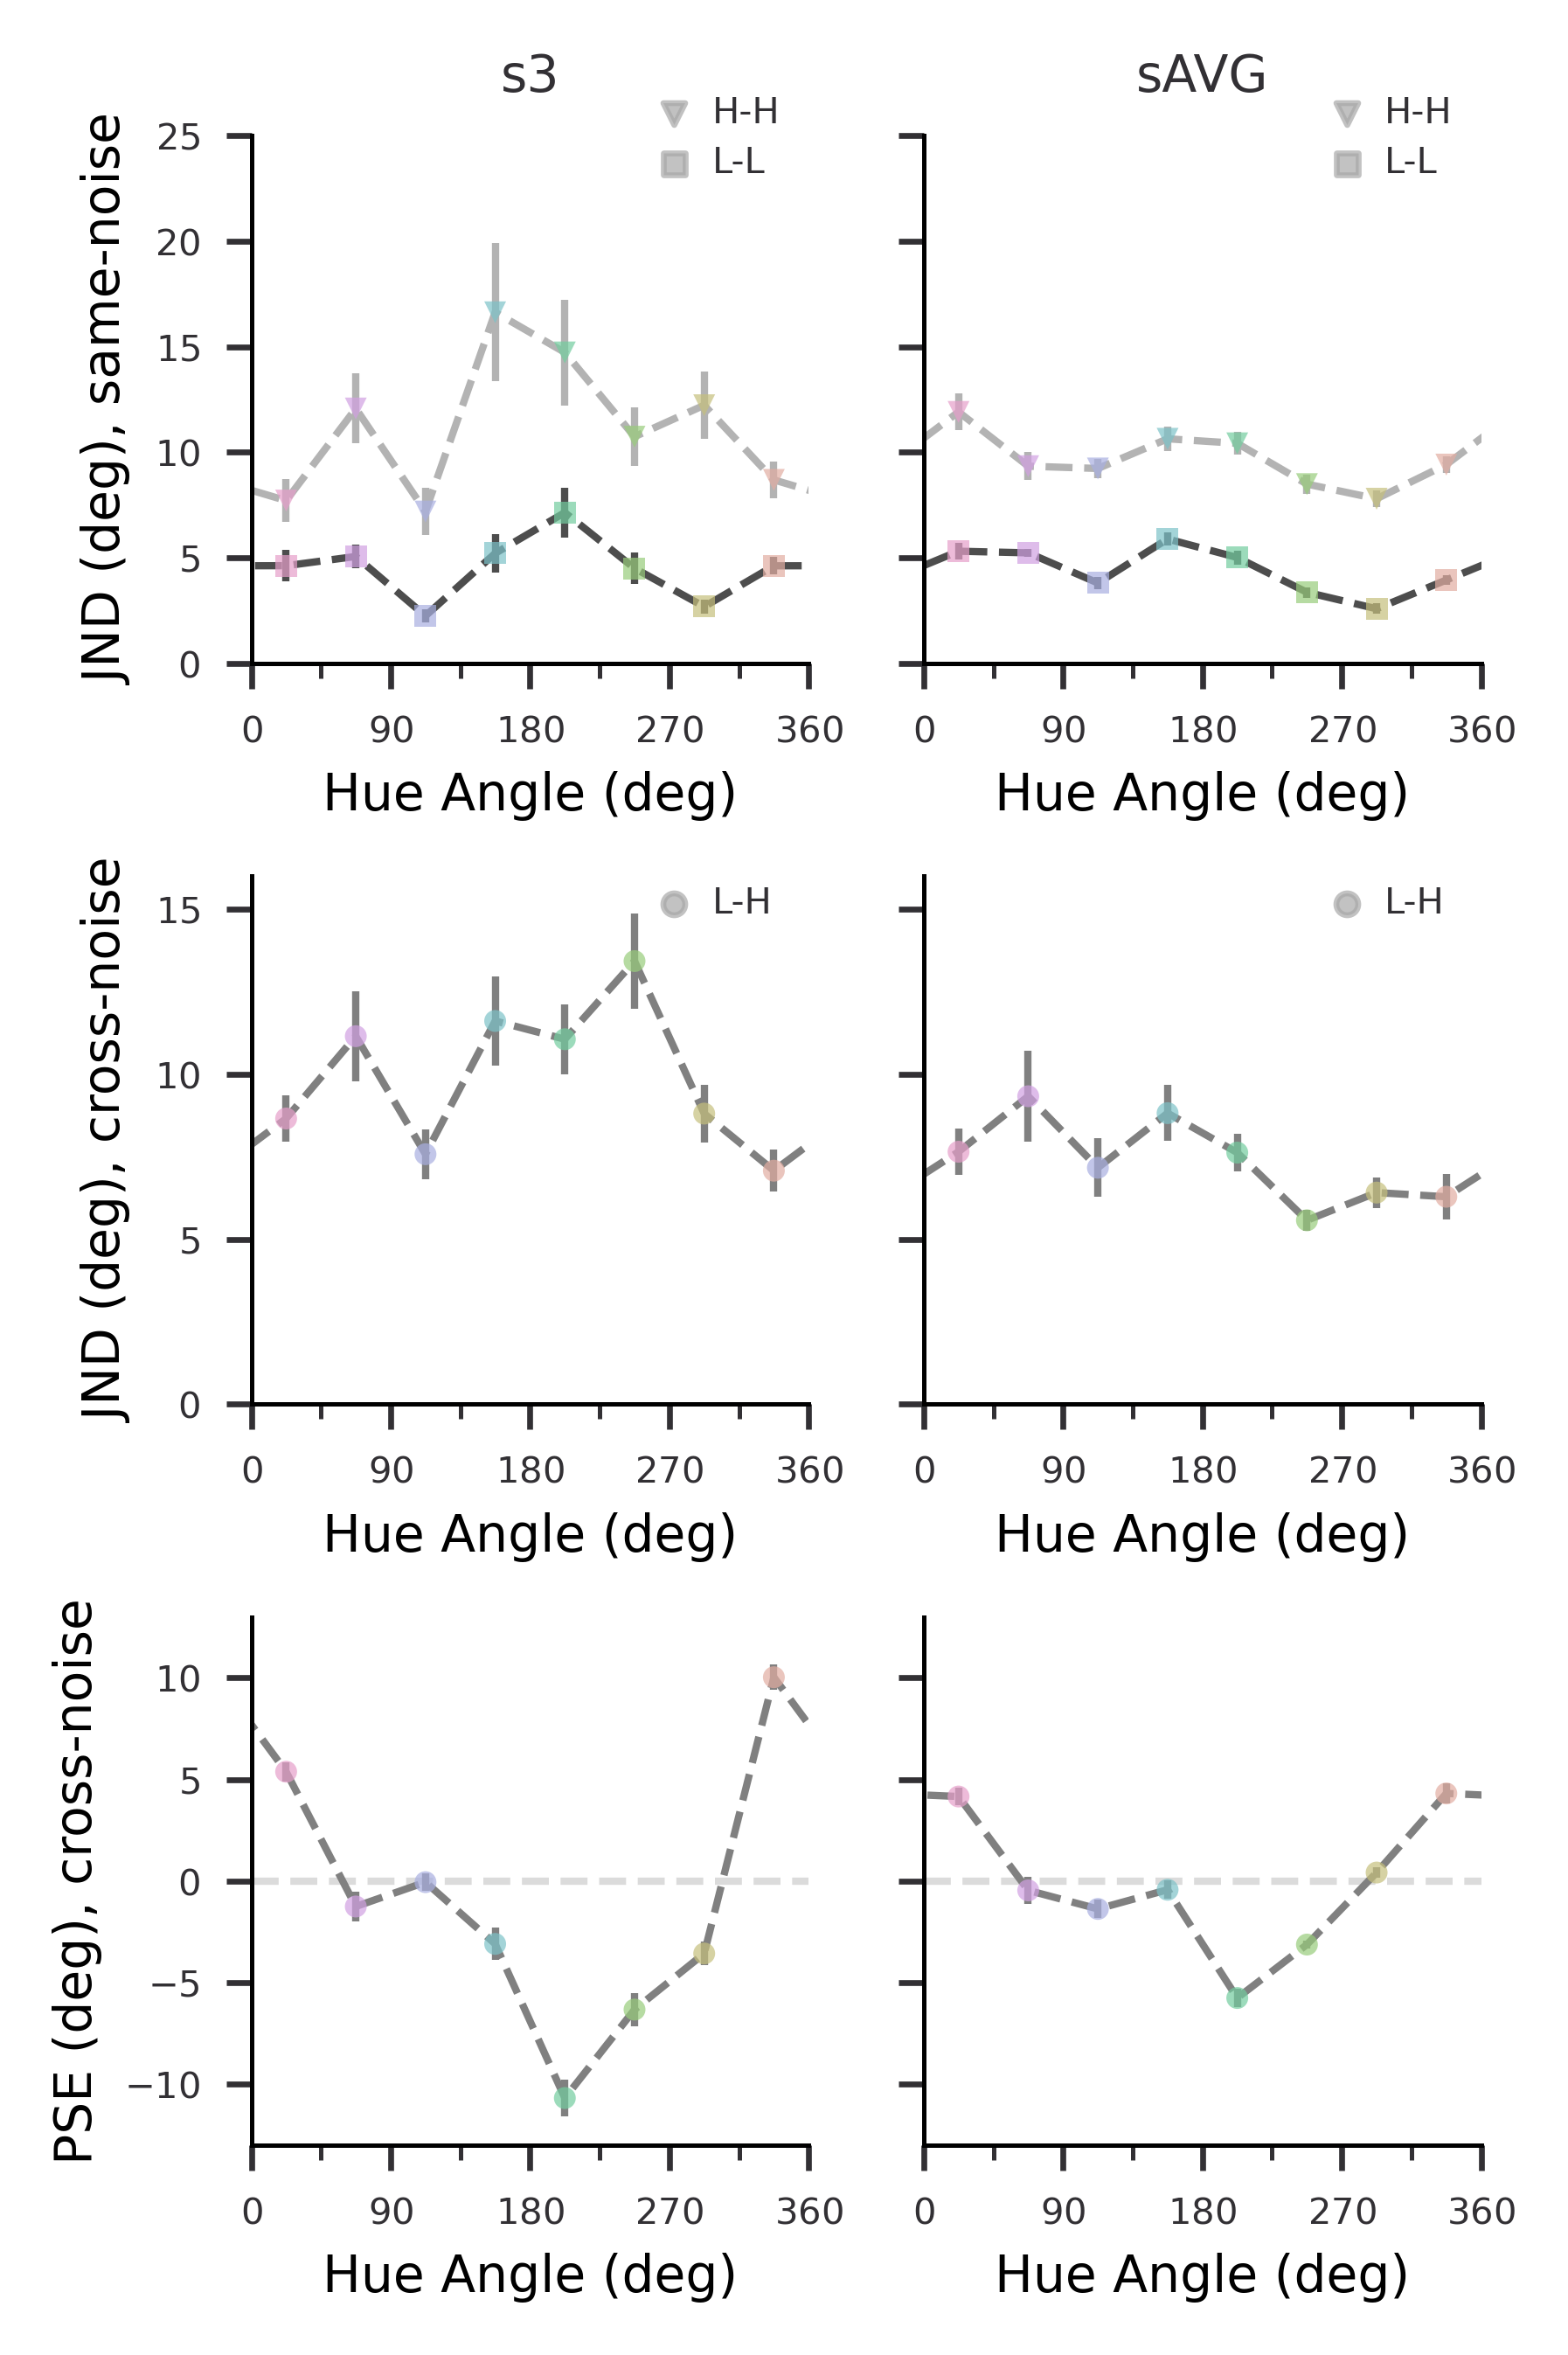

In [5]:
behavioral_subplots(pd.concat([all_pf_estim_4plot.query("subject == @sel_sub"), sAVG_pf_estm_4plot]), ylim=[[0, 25], [0, 16], [-13, 13]], fig_name='Fig_1_abc')

## SFig 1
Supplementary Figure 1. Behavioral measurement estimates for subjects S1, S2, S3, S4, and S6 (each column, respectively). Top: hue discrimination thresholds (i.e. just noticeable difference, JND) under the same-noise condition. Middle: hue discrimination thresholds under the cross-noise condition. Bottom: Relative bias (i.e. point of subjective equality, PSE, under the cross-noise condition), as the hue angle by which the high-noise stimulus was rotated counter-clockwise to be perceived as the low-noise stimulus. Bars denote one standard deviation error on the estimates.

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


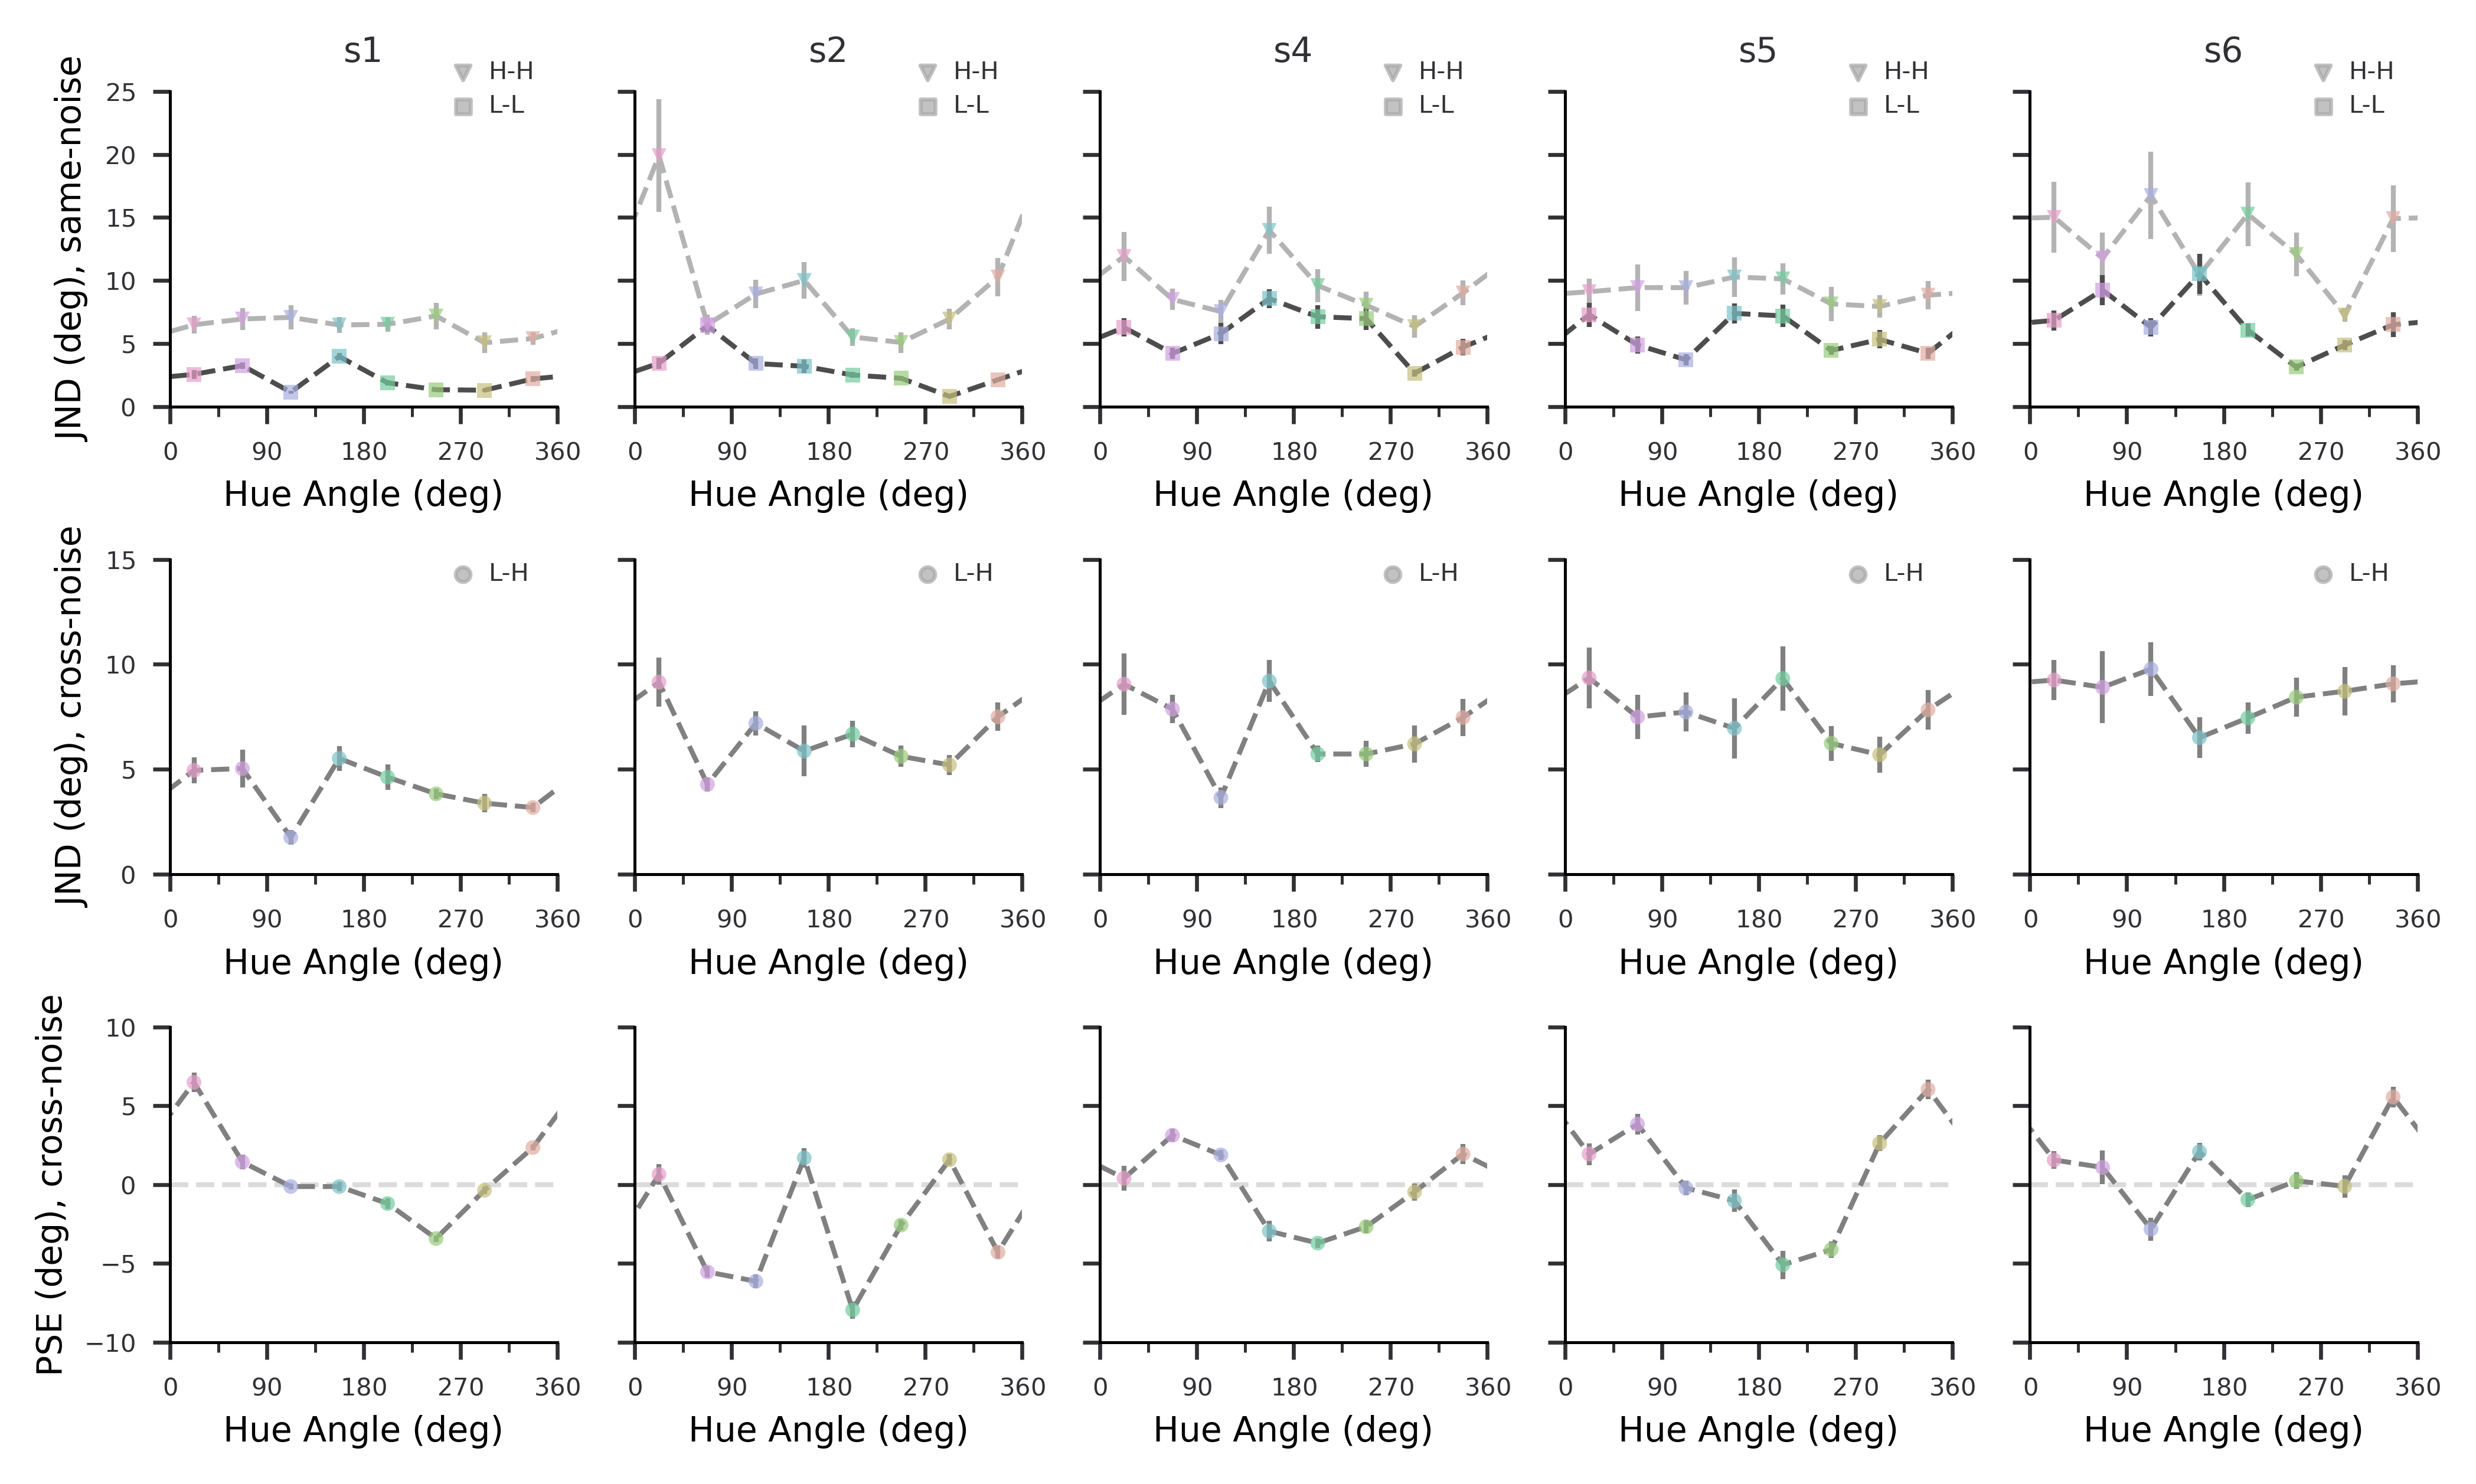

In [7]:
behavioral_subplots(all_pf_estim_4plot.query("subject != @sel_sub"), ylim=[[0, 25], [0, 15], [-10, 10]], fig_name='SFig_1')

## SFig 2

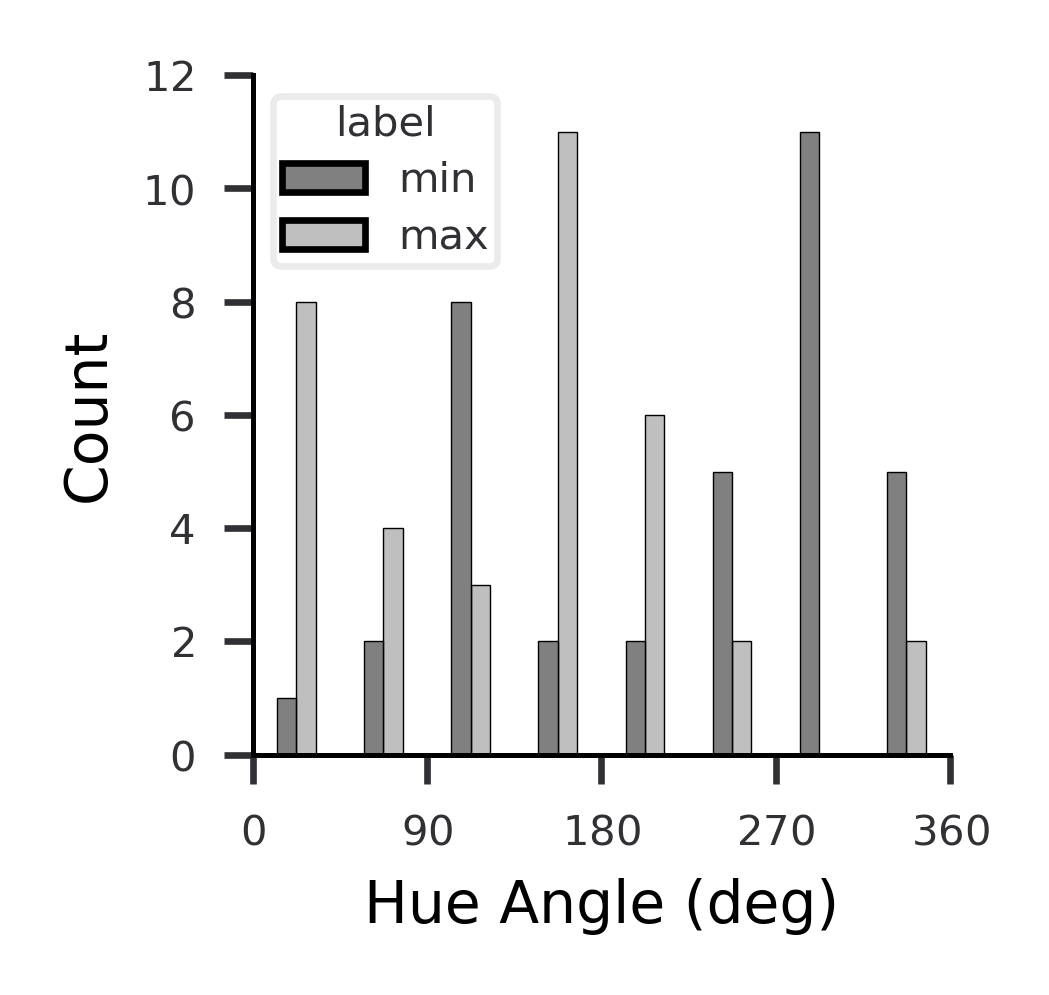

In [ ]:
fig, axes = plt.subplots(figsize=(1.5, 1.5),nrows=1, ncols=1, sharex=True)

dips_l = []
peaks_l = []
for idx, c in enumerate(['LL', 'HH', 'LH']):
    dips = all_pf_estm.query("condition == @c")[['subject', 'Hue Angle', 'JND']].sort_values(by=['subject', 'JND'], ascending=True).groupby('subject').head(2)
    dips['label'] = 'min'
    peaks = all_pf_estm.query("condition == @c")[['subject', 'Hue Angle', 'JND']].sort_values(by=['subject', 'JND'], ascending=True).groupby('subject').tail(2)
    peaks['label'] = 'max'
    dips_l.append(dips)
    peaks_l.append(peaks)
    # sns.histplot(x=dips,color=cond_cfg['linecolors'][c], ax=axes[0], binwidth=45)
    # sns.histplot(x=peaks,color=cond_cfg['linecolors'][c], ax=axes[1], binwidth=45)
    # axes[0].hist(dips, color=cond_cfg['linecolors'][c], alpha=.5, bins=16)
    # axes[1].hist(peaks, color=cond_cfg['linecolors'][c], alpha=.5, bins=16)
# sns.histplot(data=pd.concat(dips_l, ignore_index=True), x='Hue Angle', color='darkgray', ax=axes[0], discrete=True, binwidth=22.5, fill=True, stat='count', shrink=10)
# sns.histplot(data=pd.concat(peaks_l, ignore_index=True), x='Hue Angle',color='darkgray', ax=axes[1], discrete=True, binwidth=22.5, fill=True, stat='count', shrink=10)
# axes[1].set_xlim([0, 360])
# axes[1].set_xticks(np.arange(0, 360+45, 90))
# axes[1].set_xlabel("Hue Angle (deg)")
# axes[0].set_yticks(np.arange(0, 16, 5))
# axes[1].set_yticks(np.arange(0, 16, 5))

sns.histplot(data=pd.concat(dips_l+peaks_l, ignore_index=True), x='Hue Angle', hue='label', multiple='dodge', 
            ax=axes, discrete=True, binwidth=22.5, fill=True, stat='count', shrink=20, palette='gray')
plt.xlim([0, 360])
plt.xticks(np.arange(0, 360+45, 90))
# plt.xticks(np.arange(22.5, 360+45, 45))
plt.xlabel("Hue Angle (deg)")

plt.savefig(f"{fig_dir}/Fig_1d.pdf", bbox_inches='tight', dpi=600)

# SFig 3

same-noise bias

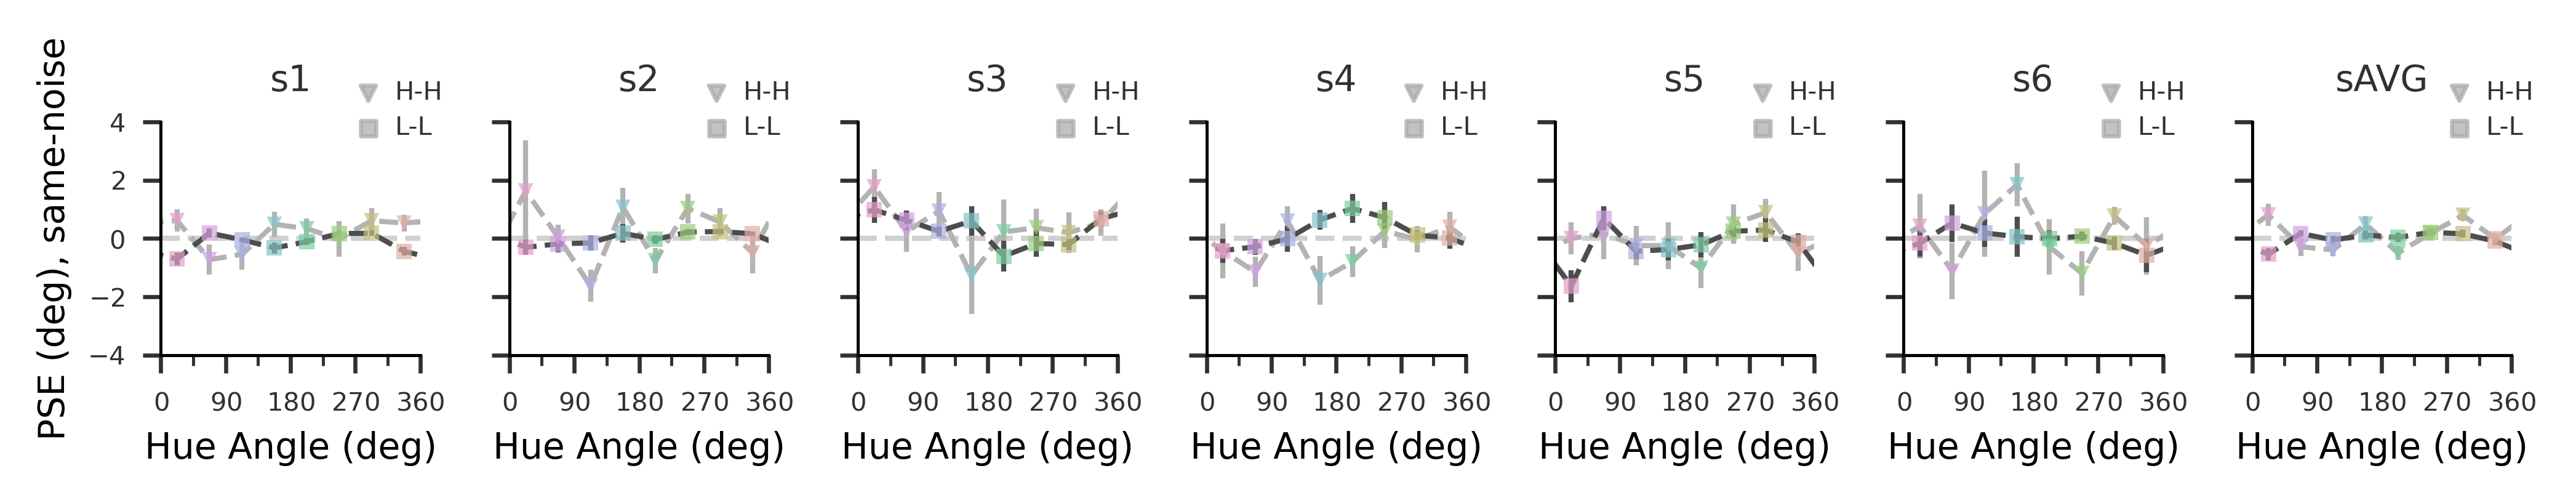

In [8]:
pf_estim_4plot = pd.concat([all_pf_estim_4plot, sAVG_pf_estm_4plot], ignore_index=True)
subs = pf_estim_4plot.subject.unique()
n_sub = len(subs)

marker_color = [colorcode[h] if 0<=h<360 else (colorcode[h+360] if h<0 else colorcode[h-360]) for h in hue_angles]

capsize = 4
alpha = {'line': 1., 'marker': 0.7}
subplot_width, subplot_height = 1., 1.3

fig, axes = plt.subplots(figsize=(subplot_width * n_sub, subplot_height * 1), nrows=1, ncols=n_sub, sharex='none', sharey='row')
    
for i_sub, sub in enumerate(subs):
    sub_estimate = pf_estim_4plot.query("subject == @sub")

    # Plot JND, same-noise
    for key, grp in sub_estimate.query("condition=='LL' or condition=='HH'").groupby('condition'):

        axes[i_sub].set_title(sub)
        axes[i_sub].errorbar(x=grp['Hue Angle'], y=grp['PSE'], yerr=grp['PSE_err'],
                                c=cond_cfg['linecolors'][key], linestyle='dashed', capsize=capsize, zorder=2)
        axes[i_sub].scatter(x=grp['Hue Angle'].values, y=grp['PSE'].values, c=marker_color,
                                 marker=cond_cfg['markers'][key], edgecolors='none', alpha=alpha['marker'],
                                label=cond_cfg['labels'][key], zorder=3)
        axes[i_sub].hlines(0, 0, 360, alpha=alpha['marker'],  colors=[.8, .8, .8], linestyle='--', zorder=1)
        # axes[i_sub].set_yticks(np.arange(0, 30, step=5))

        # ax[0].set_yscale('log')
        # ax[0].set_ylim([10**(0), 10**1.5])
        axes[i_sub].set_ylim([-4, 4])  
        leg = axes[i_sub].legend(loc=legend_loc, frameon=False, handletextpad=0.05)
        [marker.set_color([.66, .66, .66]) for marker in leg.legendHandles]
        
    # # Plot PSE, cross-noise
    # axes[2, i_sub].errorbar(x=estimates_LH['Hue Angle'], y=estimates_LH['PSE'], yerr=estimates_LH['PSE_err'],
    #                 c=cond_cfg['linecolors']['LH'], linestyle='dashed', capsize=capsize, zorder=2)
    # axes[2, i_sub].scatter(x=estimates_LH['Hue Angle'], y=estimates_LH['PSE'],
    #                 c=marker_color, marker=cond_cfg['markers']['LH'], edgecolors='none', alpha=alpha['marker'],
    #                 label='L-H', zorder=3)

    # axes[2, i_sub].hlines(0, 0, 360, alpha=alpha['marker'],  colors=[.8, .8, .8], linestyle='--', zorder=1)
    # axes[2, i_sub].set_yticks(np.arange(-20, 20, step=5))
    # axes[2, i_sub].set_ylim(ylim[2])   


    axes[i_sub].set_xlim([0, 360])
    axes[i_sub].xaxis.set_minor_locator(plt.FixedLocator(x_minor_ticks))
    axes[i_sub].xaxis.set_major_locator(plt.FixedLocator(x_major_ticks))
    axes[i_sub].set_xlabel('Hue Angle (deg)')
    
    if n_sub >= 2:
        axes[0].set_ylabel('PSE (deg), same-noise')



plt.tight_layout()
plt.show()

fig.savefig(fig_dir + "SFig_6" +".pdf", bbox_inches='tight', dpi=600)


# Results 2

In [59]:
from data_analysis.fit_bstrp import fit_bstrp
# from data_analysis.estimate_likelihood import rect_sin
from data_analysis.estimate_likelihood import mixed_sin

In [164]:
def jnd_mat_subplots(estimates, ylim = 15, fig_name=None):
    

    subs = estimates.subject.unique()
    n_sub = len(subs)
    
    subplot_width, subplot_height = 1.5, 1.5
    # row as sub, 3 columns as jnd, matrix_ll, matrix_hh
    fig, axes = plt.subplots(figsize=(subplot_width * 3, subplot_height * n_sub), nrows=n_sub, ncols=3, sharex='none', sharey='none')

    for i_sub, sub in enumerate(subs):

        sub_estimate = estimates.query("subject == @sub")
        grp_l, grp_h = sub_estimate.query('condition == "LL"'), sub_estimate.query('condition == "HH"')
        
        pickle_l, pickle_h = f"{model_path}/{sub}/{sub}_jnd_fit_l.pickle", f"{model_path}/{sub}/{sub}_jnd_fit_h.pickle", 
        with open(pickle_l, 'rb') as f:
            fit_jnd_l = pickle.load(f)
        with open(pickle_h, 'rb') as f:
            fit_jnd_h = pickle.load(f)
        
        mat_l, mat_h = np.load(f"{model_path}/{sub}/{sub}_mat_l.npy"), np.load(f"{model_path}/{sub}/{sub}_mat_h.npy")
        edges_l, edges_h = np.load(f"{model_path}/{sub}/{sub}_mat_edges_l.npy"), np.load(f"{model_path}/{sub}/{sub}_mat_edges_h.npy"), 
        extent_l = [edges_l[0][0], edges_l[0][-1], edges_l[1][0], edges_l[1][-1]]
        extent_h = [edges_h[0][0], edges_h[0][-1], edges_h[1][0], edges_h[1][-1]]
        
        ll = {'label': 'L vs. L',
               'val': grp_l['JND'].values, 
               'err': grp_l['JND_err'],
               'fit': fit_jnd_l,
               'marker': cond_cfg['markers']['LL'],
                'linecolor': cond_cfg['linecolors']['LL'],
                'mat': mat_l,
                'extent': extent_l}
        hh = {'label': 'H vs. H',
               'val': grp_h['JND'].values, 
               'err': grp_h['JND_err'],
               'fit': fit_jnd_h,
               'marker':  cond_cfg['markers']['HH'],
                'linecolor': cond_cfg['linecolors']['HH'],
                'mat': mat_h,
                'extent': extent_h}

        # plot JND fits
        for d in [ll, hh]:
            axes[i_sub, 0].set_title(sub)
            axes[i_sub, 0].scatter(hue_angles, d['val'], marker=d['marker'], linewidth=marker_linewidth,s=marker_size,facecolors='none', edgecolors='gray', label=d['label'], zorder=3)
            axes[i_sub, 0].errorbar(x=hue_angles, y=d['val'], yerr=d['err'], ls='none', linewidth=marker_linewidth, color='gray', zorder=2)
            # axes[i_sub, 0].plot(x_grid, rect_sin(x_grid, *d['fit']['params']), color=d['linecolor'])
            axes[i_sub, 0].plot(x_grid, mixed_sin(x_grid, *d['fit']['params']), color=d['linecolor'])
            axes[i_sub, 0].fill_between(x_grid, d['fit']['bounds'][0],  d['fit']['bounds'][1], alpha=0.2, color='gray')

            axes[i_sub, 0].set_yticks(np.arange(0, 25, step=5))
            axes[i_sub, 0].set_ylim([0, ylim])
            # # axes[i_sub].set_yscale('log')
            # # axes[i_sub].set_ylim([10**(-0.15), 10**1.5])
            axes[i_sub, 0].set_xlabel('Hue Angle (deg)')
            axes[i_sub, 0].set_ylabel('JND (deg)')

            leg = axes[i_sub, 0].legend(loc=(0.65, 0.85), frameon=False)
            # leg.get_frame().set_linewidth(0.0)
            # leg.get_frame().set_facecolor('none')
        
        axes[i_sub, 1].set_title('Low-noise')
        axes[i_sub, 2].set_title('High-noise')

        for i_col, d in zip([1, 2], [ll, hh]):
            im = axes[i_sub, i_col].imshow(d['mat'], origin='lower', cmap='gray', extent=d['extent'])

            if i_col == 1:
                ticks = [0, 2e-4, 4e-4]
            else:
                ticks= [0, 1e-4, 2e-4]
            cb = fig.colorbar(im, ax=axes[i_sub, i_col], pad = 0.15, ticks=ticks)
            cb.formatter.set_powerlimits((0, 0)) 
            cb.ax.locator_params(nbins=5)

            axes[i_sub, i_col].set_ylim([0, 360])
            axes[i_sub, i_col].yaxis.set_minor_locator(plt.FixedLocator(x_minor_ticks))
            axes[i_sub, i_col].yaxis.set_major_locator(plt.FixedLocator(x_major_ticks))
            axes[i_sub, i_col].set_ylabel('Measurement (deg)')
            axes[i_sub, i_col].set_xlabel('True Stimulus (deg)')
    
        # Set axis info
        for i_col in range(3):
            axes[i_sub, i_col].set_xlim([0, 360])
            axes[i_sub, i_col].xaxis.set_minor_locator(plt.FixedLocator(x_minor_ticks))
            axes[i_sub, i_col].xaxis.set_major_locator(plt.FixedLocator(x_major_ticks))

    plt.tight_layout()
    plt.show()

    if fig_name is not None:
        fig.savefig(fig_dir + fig_name +".pdf", bbox_inches='tight', dpi=600)


In [40]:
def jnd_subplots(estimates, ylim = 15, fig_name=None):

    subs = estimates.subject.unique()
    n_sub = len(subs)
    
    subplot_width, subplot_height = 1.5, 1.5
    # row as sub, 3 columns as jnd, matrix_ll, matrix_hh
    fig, axes = plt.subplots(figsize=(subplot_width * 3, subplot_height * n_sub), nrows=n_sub, ncols=3, sharex='none', sharey='none')

    for i_sub, sub in enumerate(subs):

        sub_estimate = estimates.query("subject == @sub")
        grp_lh = sub_estimate.query('condition == "LH"')
        
        pickle_lh =  f"{model_path}/{sub}/{sub}_jnd_fit_lh.pickle",
        with open(pickle_lh, 'rb') as f:
            fit_jnd_lh = pickle.load(f)
    
        d = {'label': 'L vs. H',
               'val': grp_lh['JND'].values, 
               'err': grp_lh['JND_err'],
               'fit': fit_jnd_lh,
               'marker': cond_cfg['markers']['LH'],
                'linecolor': cond_cfg['linecolors']['LH']}


        axes[i_sub, 0].set_title(sub)
        axes[i_sub, 0].scatter(hue_angles, d['val'], marker=d['marker'], linewidth=marker_linewidth,s=marker_size,facecolors='none', edgecolors='gray', label=d['label'], zorder=3)
        axes[i_sub, 0].errorbar(x=hue_angles, y=d['val'], yerr=d['err'], ls='none', linewidth=marker_linewidth, color='gray', zorder=2)
        axes[i_sub, 0].plot(x_grid, rect_sin(x_grid, *d['fit']['params']), color=d['linecolor'])
        axes[i_sub, 0].fill_between(hue_angles, d['fit']['bounds'][0],  d['fit']['bounds'][1], alpha=0.2, color='gray')

        axes[i_sub, 0].set_yticks(np.arange(0, 20, step=5))
        axes[i_sub, 0].set_ylim([0, ylim])
        # # axes[i_sub].set_yscale('log')
        # # axes[i_sub].set_ylim([10**(-0.15), 10**1.5])
        axes[i_sub, 0].set_xlabel('Hue Angle (deg)')
        axes[i_sub, 0].set_ylabel('JND (deg)')

        leg = axes[i_sub, 0].legend(loc=(0.65, 0.85), frameon=False)
        # leg.get_frame().set_linewidth(0.0)
        # leg.get_frame().set_facecolor('none')
        
        # Set axis info
        for i_col in range(3):
            axes[i_sub, i_col].set_xlim([0, 360])
            axes[i_sub, i_col].xaxis.set_minor_locator(plt.FixedLocator(x_minor_ticks))
            axes[i_sub, i_col].xaxis.set_major_locator(plt.FixedLocator(x_major_ticks))

    plt.tight_layout()
    plt.show()

    if fig_name is not None:
        fig.savefig(fig_dir + fig_name +".pdf", bbox_inches='tight', dpi=600)


In [ ]:
# jnd_subplots(pd.concat([all_pf_estim_4plot.query("subject == @sel_sub"), sAVG_pf_estm_4plot]), ylim=16, fig_name='Fig_2_lh_poster')
jnd_subplots(pd.concat([all_pf_estim_4plot.query("subject == @sel_sub"), sAVG_pf_estm_4plot]), ylim=16)


## Fig 3
Figure 3. Fitted JNDs and estimated likelihood functions in same-noise conditions. (A-B) Fitted JNDs of the representative subject S5 and the average subject. JND estimates are shown with one standard deviation error. The dark and light gray lines are the fitted JNDs for L vs. L and H vs. H conditions, respectively. The gray error shades shows $\pm 1$ standard deviation of 1000 bootstrapped fitted JNDs. (C-D) Estimated likelihood functions of subject S5 (C) and the average subject (D). Each horizontal slice of the two-dimensional function represented a likelihood function of stimulus hue angle $\theta$ given a particular measurement $m$, and each vertical slice represents a measurement distribution centered on a particular $\theta$. The graycale intensity represents probability in the L vs. L condition("Low-noise", left) and in the H vs. H condition ("High-noise", right).

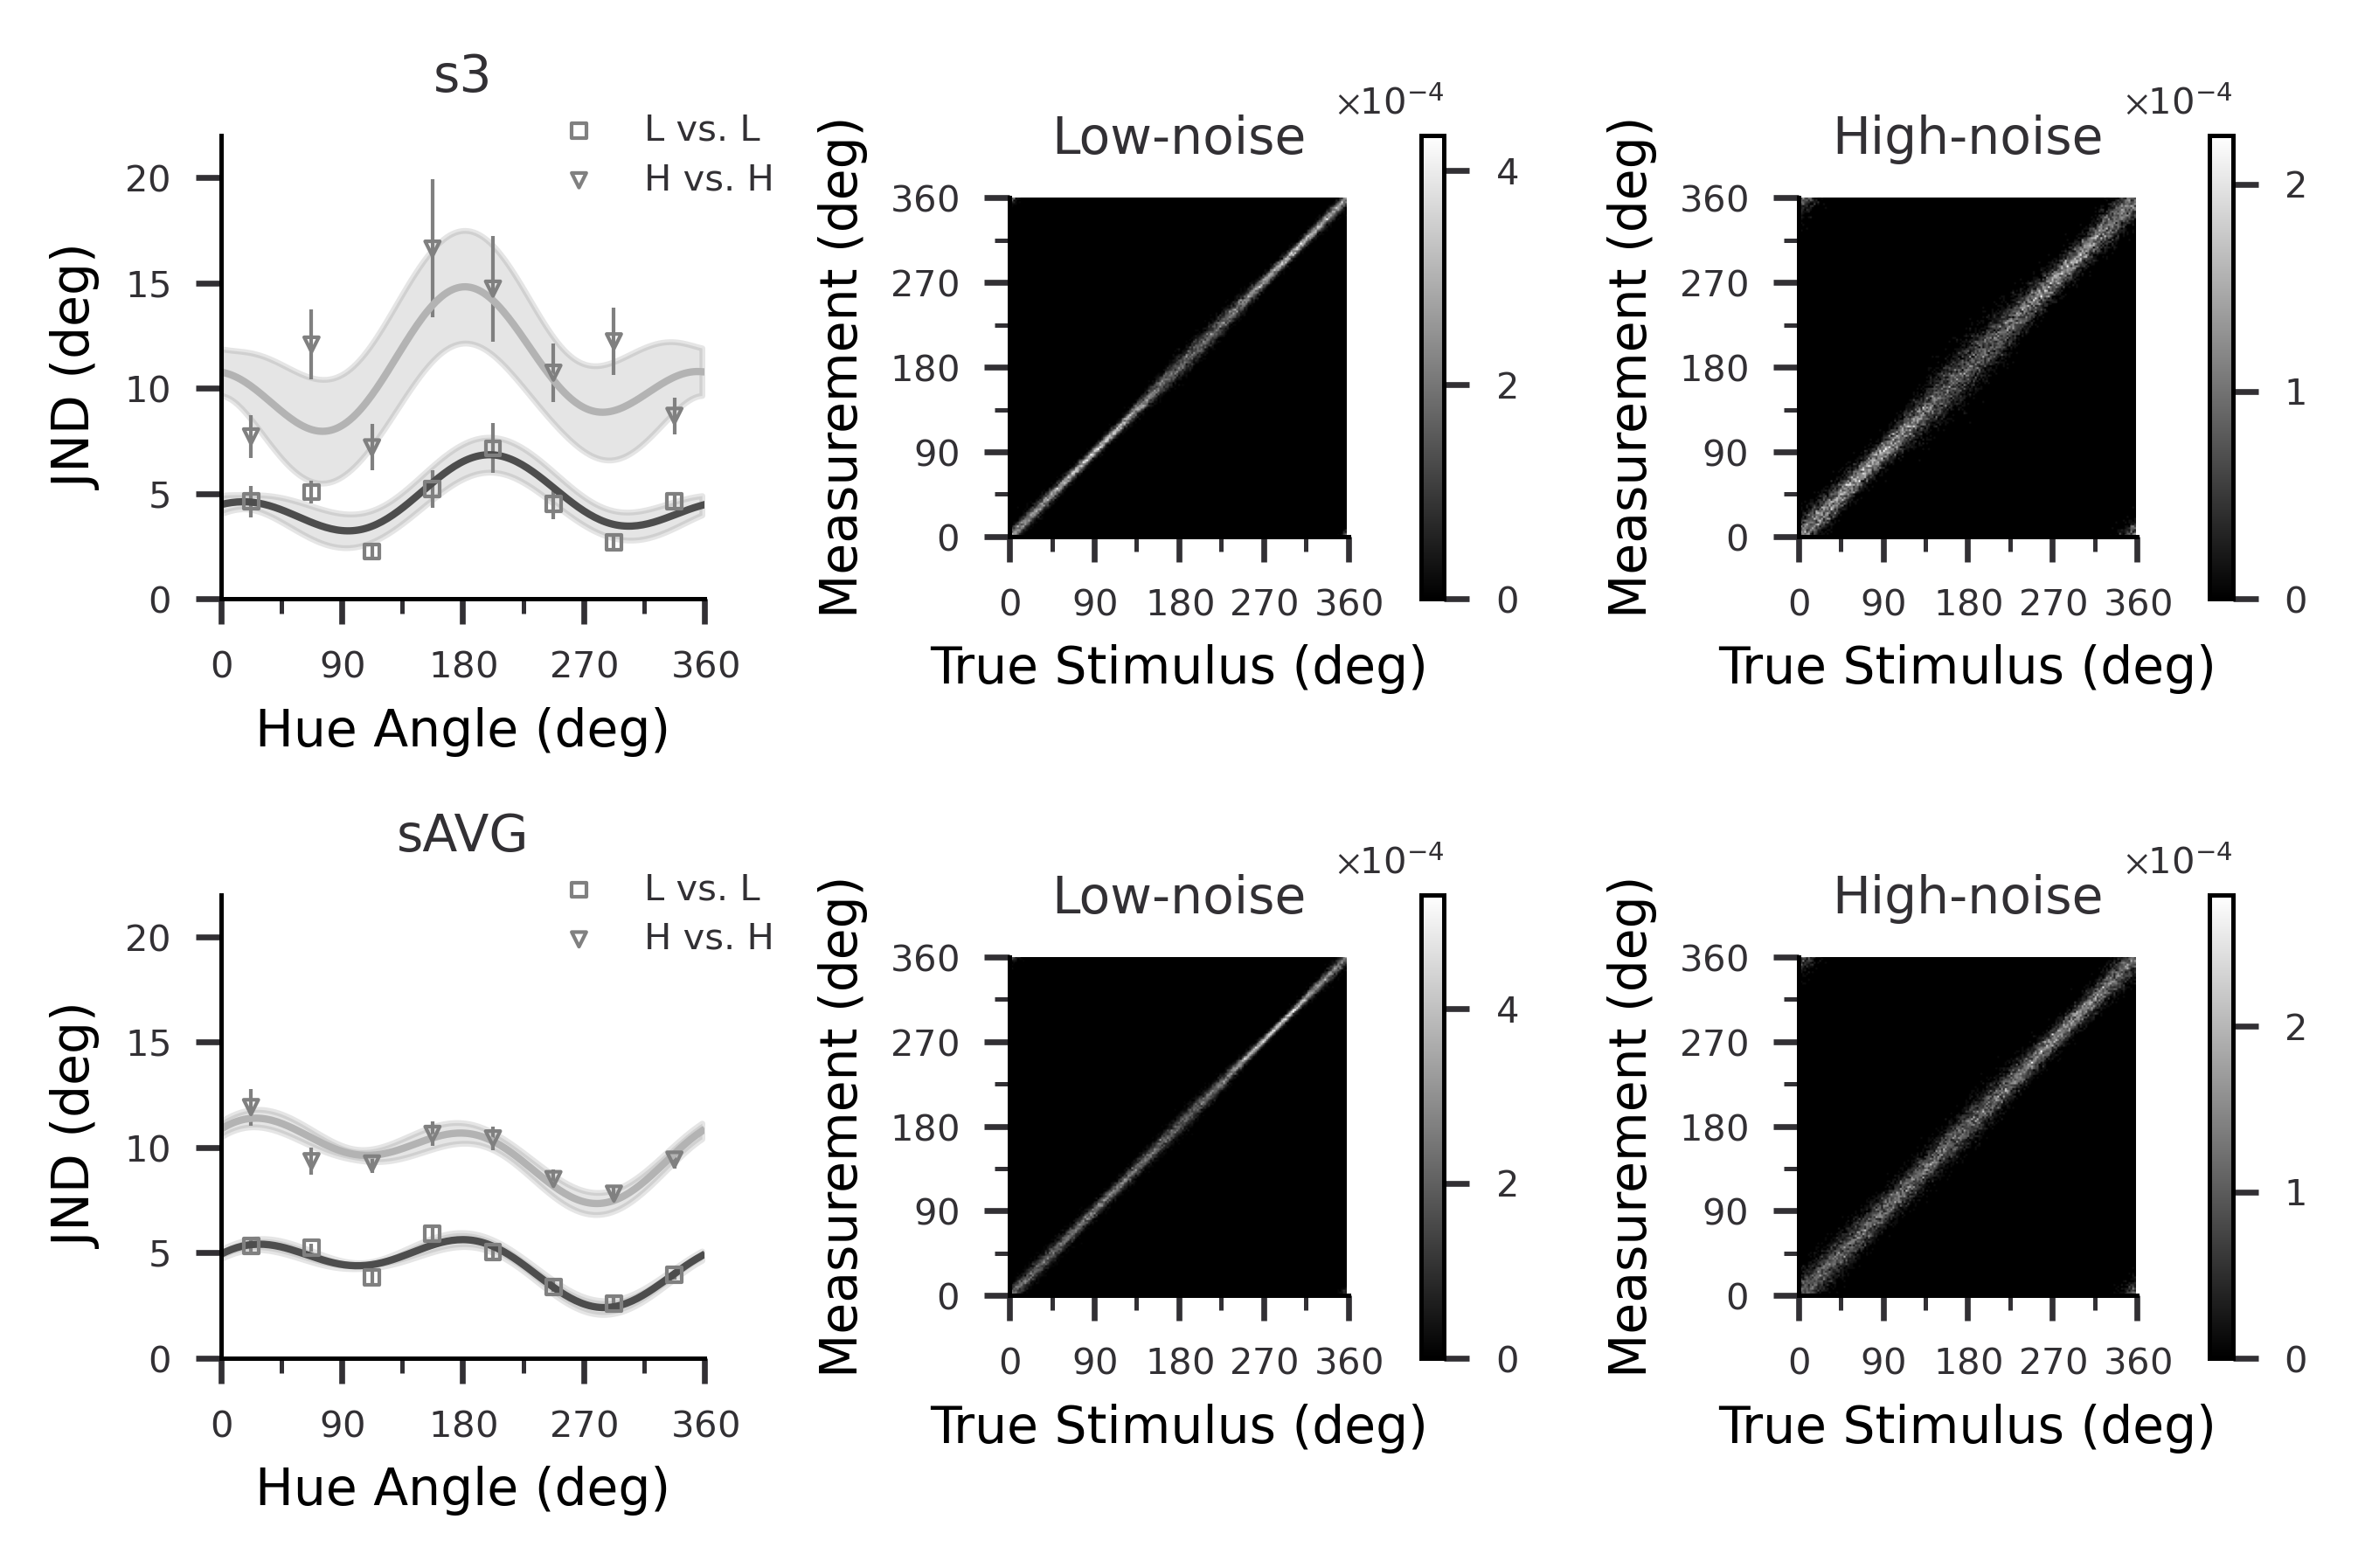

In [173]:
# jnd_mat_subplots(pd.concat([all_pf_estim_4plot.query("subject == @sel_sub"), sAVG_pf_estm_4plot]), ylim=22, fig_name='Fig_2')
jnd_mat_subplots(pd.concat([all_pf_estim_4plot.query("subject == @sel_sub"), sAVG_pf_estm_4plot]), ylim=22, fig_name='Fig_2_v2')
# jnd_mat_subplots(pd.concat([all_pf_estim_4plot.query("subject == @sel_sub"), sAVG_pf_estm_4plot]), ylim=22, fig_name=None)
# jnd_mat_subplots(all_pf_estim_4plot.query("subject == @sel_sub"), ylim=22)


##  SFig 4
Supplementary Figure 4. Fitted JNDs and estimated likelihood functions in same-noise conditions for subjects S1, S2, S3, S4, and S6 (five rows, respectively). (A) Fitted JNDs of the subjects. JND estimates are shown with one standard deviation error. The dark and light gray lines are the fitted JNDs for L vs. L and H vs. H conditions, respectively. The gray error band shows $\pm 1$ standard deviation of 1000 bootstrapped fitted JNDs. (B) Estimated likelihood functions of the subjects. Each horizontal slice of the two-dimensional function represented a likelihood function of stimulus hue angle $\theta$ given a particular measurement $m$, and each vertical slice represents a measurement distribution centered on a particular $\theta$. The graycale intensity represents probability in the L vs. L condition("Low-noise", left) and in the H vs. H condition ("High-noise", right).

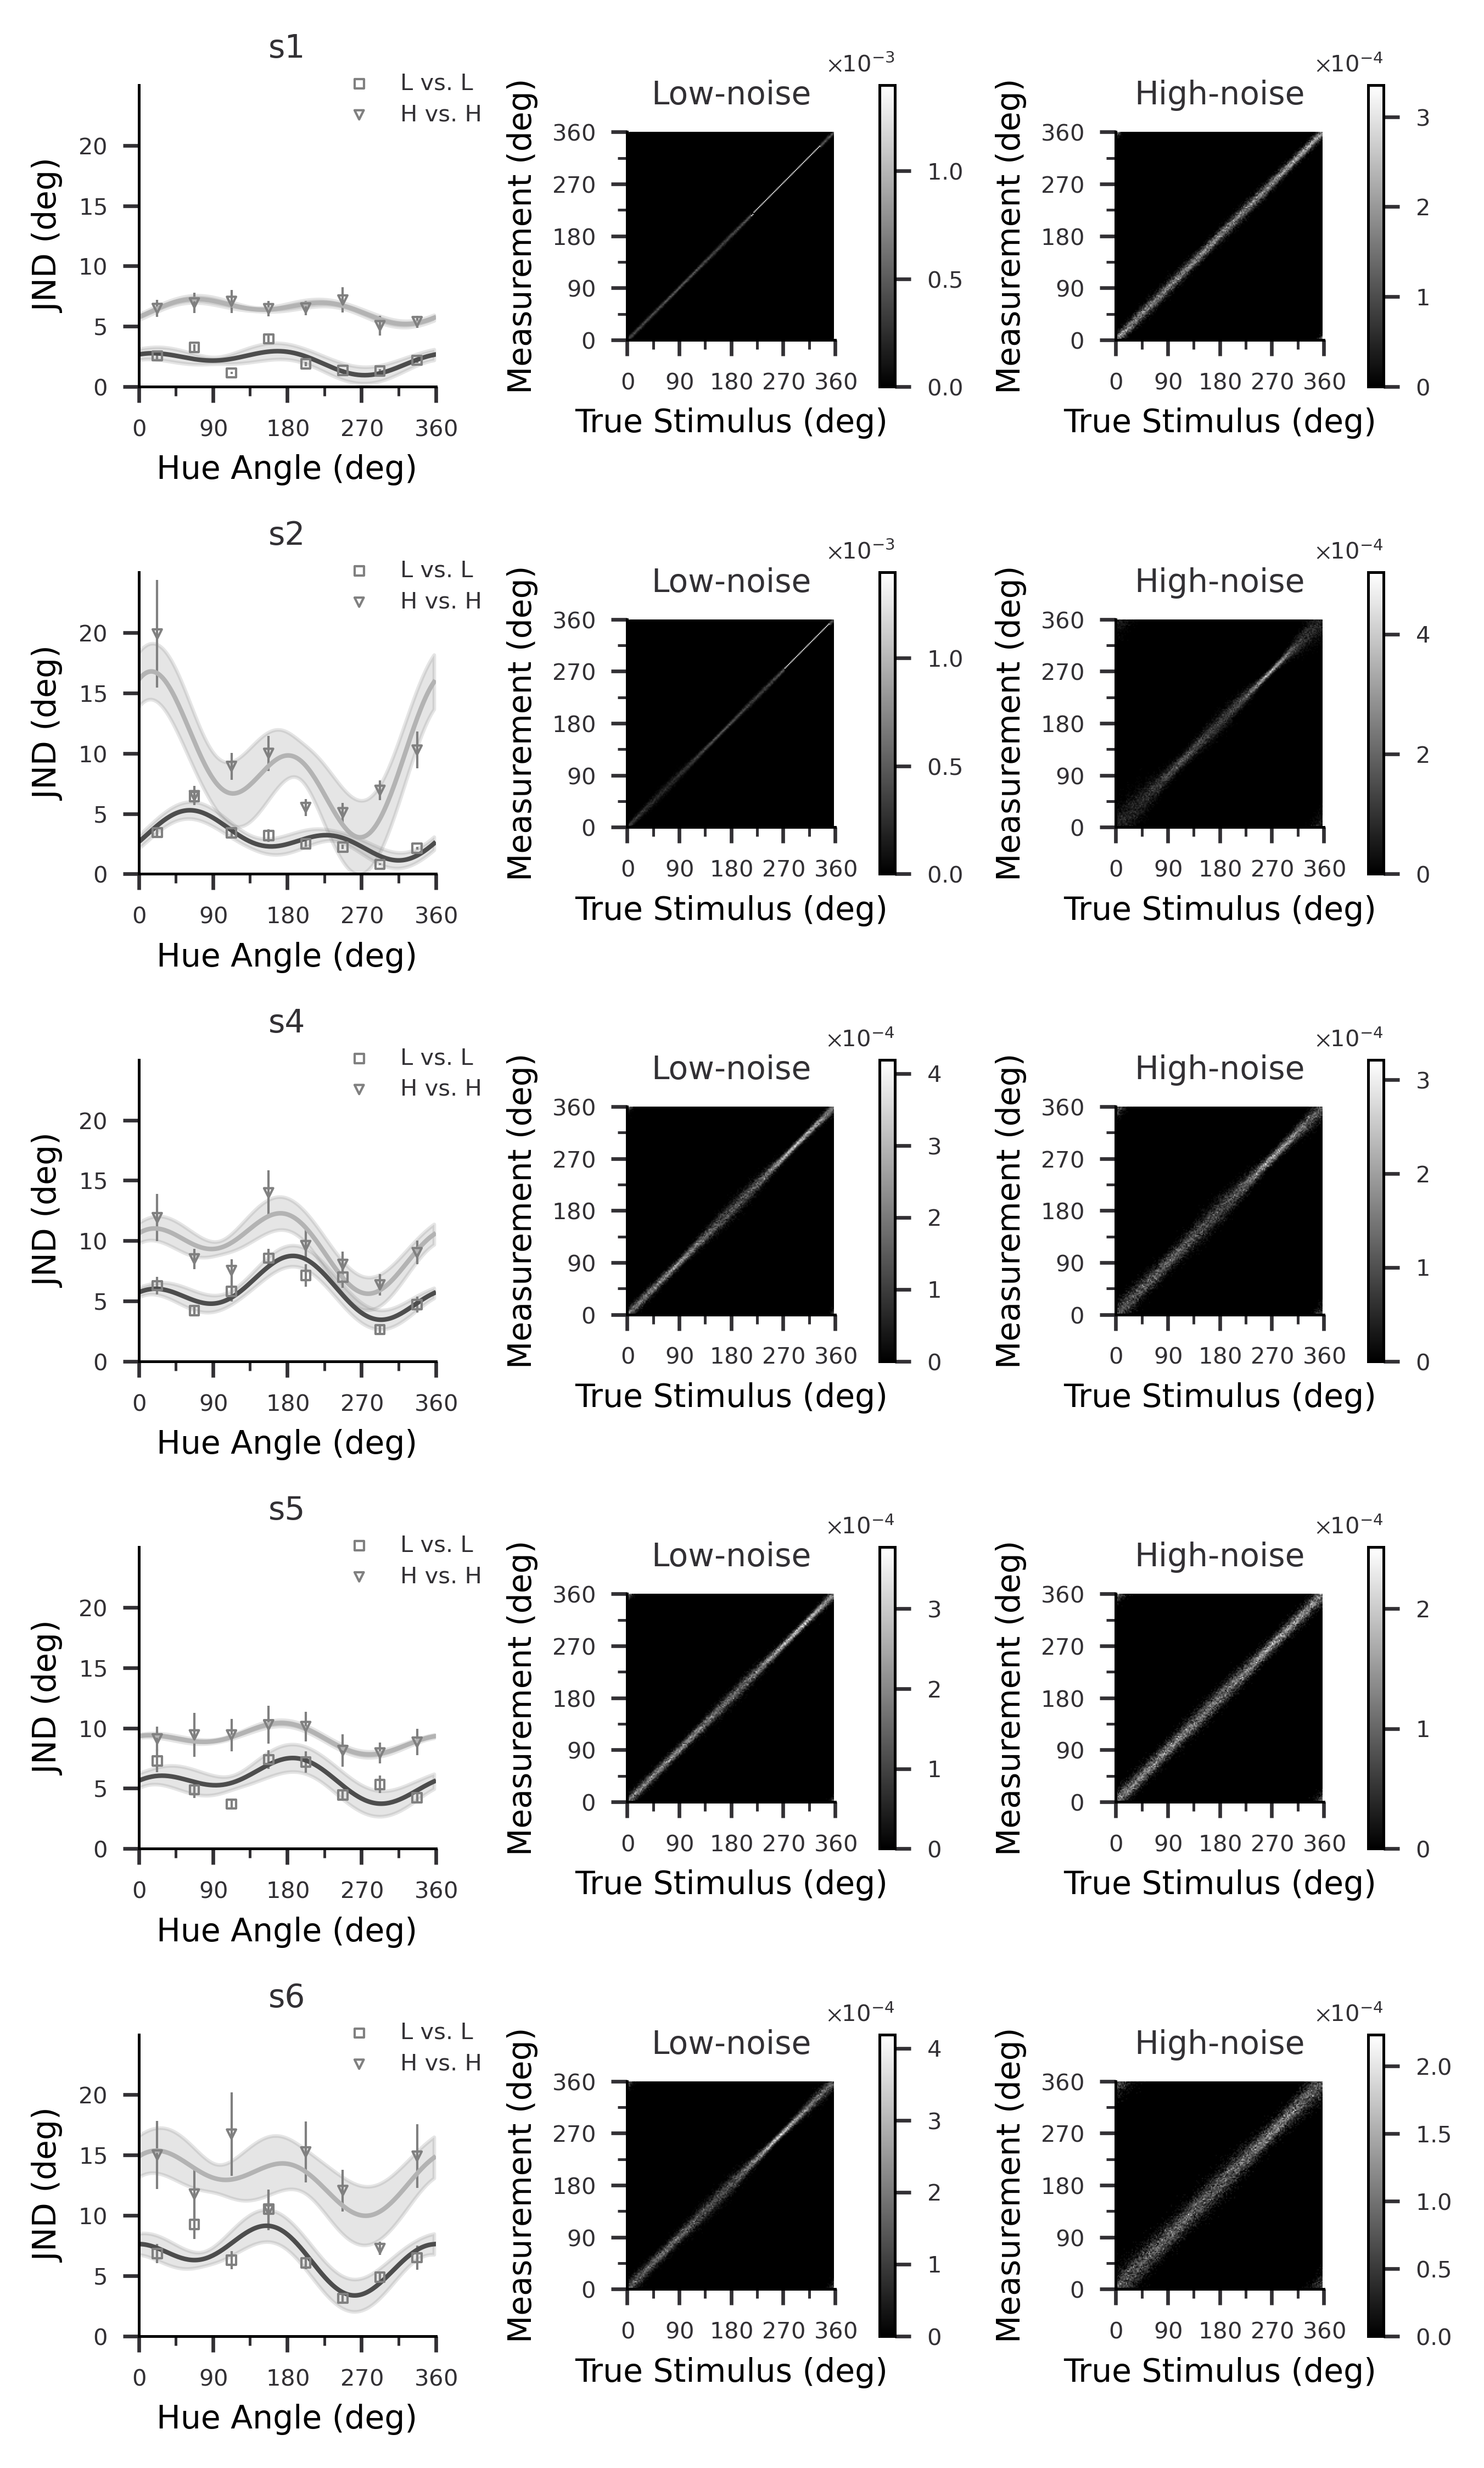

In [11]:
# jnd_mat_subplots(all_pf_estim_4plot.query("subject != @sel_sub"), ylim=25, fig_name='SFig_2')
jnd_mat_subplots(all_pf_estim_4plot.query("subject != @sel_sub"), ylim=25, fig_name='SFig_2_v2')


## Compute local min and max of fitted JND

In [48]:
fit_jnd_l_pars = []
fit_jnd_h_pars = []
fit_jnd_lh_pars = []
fit_l = []
fit_h = []
fit_lh = []
# for sub in ['s1', 's2', 's3', 's4', 's5', 's6', 'sAVG']:
for sub in ['s1', 's2', 's3', 's4', 's5', 's6']:
# for sub in ['s3']:

    pickle_l, pickle_h = f"{model_path}/{sub}/{sub}_jnd_fit_l.pickle", f"{model_path}/{sub}/{sub}_jnd_fit_h.pickle", 
    pickle_lh = f"{model_path}/{sub}/{sub}_jnd_fit_lh.pickle"
    with open(pickle_l, 'rb') as f:
        fit_jnd_l = pickle.load(f)
    with open(pickle_h, 'rb') as f:
        fit_jnd_h = pickle.load(f)
    with open(pickle_lh, 'rb') as f:
        fit_jnd_lh = pickle.load(f)

    fit_jnd_l_pars.append(fit_jnd_l['params'])
    fit_jnd_h_pars.append(fit_jnd_h['params'])
    fit_jnd_lh_pars.append(fit_jnd_lh['params'])

    fit_l.append(mixed_sin(x_grid, *fit_jnd_l['params']))
    fit_h.append(mixed_sin(x_grid, *fit_jnd_h['params']))
    fit_lh.append(mixed_sin(x_grid, *fit_jnd_lh['params']))

fit_jnd_l_pars = np.array(fit_jnd_l_pars)
fit_jnd_h_pars = np.array(fit_jnd_h_pars)
fit_jnd_lh_pars = np.array(fit_jnd_lh_pars)

fit_l = np.array(fit_l)
fit_h = np.array(fit_h)


fit_l_min_loc = np.apply_along_axis(lambda x: x_grid[find_peaks(-x, distance=60)[0]], 1, fit_l)
fit_h_min_loc = np.apply_along_axis(lambda x: x_grid[find_peaks(-x, distance=60)[0]], 1, fit_h)

from scipy.stats import circmean, circstd
fit_l_min_loc_mean, fit_l_min_loc_std =  np.rad2deg(np.apply_along_axis(circmean, 0, np.deg2rad(fit_l_min_loc))), np.rad2deg(np.apply_along_axis(circstd, 0, np.deg2rad(fit_l_min_loc)))
fit_h_min_loc_mean, fit_h_min_loc_std =  np.rad2deg(np.apply_along_axis(circmean, 0, np.deg2rad(fit_h_min_loc))), np.rad2deg(np.apply_along_axis(circstd, 0, np.deg2rad(fit_h_min_loc)))

print(f"LL fitted JND minima at {fit_l_min_loc_mean[0]} +/- {fit_l_min_loc_std[0]}, {fit_l_min_loc_mean[1]} +/- {fit_l_min_loc_std[1]}")
print(f"HH fitted JND minima at {fit_h_min_loc_mean[0]} +/- {fit_h_min_loc_std[0]}, {fit_h_min_loc_mean[1]} +/- {fit_h_min_loc_std[1]}")



LL fitted JND minima at 97.25084279473482 +/- 28.405313006015433, 290.74979559120794 +/- 18.06959013254019
HH fitted JND minima at 101.64116712062017 +/- 25.334283909548915, 284.53887929773316 +/- 18.037845589283894


In [7]:
fit_l_max_loc = np.apply_along_axis(lambda x: x_grid[find_peaks(x, distance=60)[0]], 1, fit_l)
fit_h_max_loc = np.apply_along_axis(lambda x: x_grid[find_peaks(x, distance=60)[0]], 1, fit_h)

from scipy.stats import circmean, circstd
fit_l_max_loc_mean, fit_l_max_loc_std =  np.rad2deg(np.apply_along_axis(circmean, 0, np.deg2rad(fit_l_max_loc))), np.rad2deg(np.apply_along_axis(circstd, 0, np.deg2rad(fit_l_max_loc)))
fit_h_max_loc_mean, fit_h_max_loc_std =  np.rad2deg(np.apply_along_axis(circmean, 0, np.deg2rad(fit_h_max_loc))), np.rad2deg(np.apply_along_axis(circstd, 0, np.deg2rad(fit_h_max_loc)))

print(f"LL fitted JND maxima at {fit_l_max_loc_mean[0]} +/- {fit_l_max_loc_std[0]}, {fit_l_max_loc_mean[1]} +/- {fit_l_max_loc_std[1]}")
print(f"HH fitted JND maxima at {fit_h_max_loc_mean[0]} +/- {fit_h_max_loc_std[0]}, {fit_h_max_loc_mean[1]} +/- {fit_h_max_loc_std[1]}")

LL fitted JND maxima at 39.422704881300845 +/- 47.107127891338735, 186.74961235037392 +/- 23.574615771658603
HH fitted JND maxima at 34.25390473551698 +/- 54.75906825809095, 186.52278775040705 +/- 55.592633820773784


In [49]:
fit_l_min = np.apply_along_axis(lambda x: x[find_peaks(-x, distance=60)[0]], 1, fit_l)
# fit_h_min = np.apply_along_axis(lambda x: x[find_peaks(-x, distance=60)[0]], 1, fit_h)
fit_lh_min = np.apply_along_axis(lambda x: x[find_peaks(-x, distance=60)[0]], 1, fit_lh)
fit_lh_min

array([[4.03410552, 2.60966842],
       [5.67893068, 4.95805345],
       [8.93345309, 7.01878445],
       [5.98610937, 5.1377035 ],
       [7.40518989, 5.65870174],
       [6.97301309, 8.57953082]])

# Results 3

In [128]:
def priors_subplots(subs, priors, priors_without_btrp=None, fig_name=None, ylim=None):
    n_sub = len(subs)

    sub_priors = priors.query("sub in @subs")
    if n_sub <= 5:
        subplot_width, subplot_height = 1.4, 1.4
    else:
        subplot_width, subplot_height = 1., 1.3
    
    sub_priors['Prior'] = sub_priors['Prior']/2.

    # add boostrap index label
    sub_priors['i_btrp'] = np.tile(np.repeat(np.arange(1, 101, 1), len(x_grid)), n_sub)

    # find idx where the max value is in each boostrap prior for each subject
    sub_priors_peakidx = sub_priors.groupby(['sub', 'i_btrp'])['Prior'].idxmax().reset_index()

    # find the hue angle has the max value in each boostrap prior for each subject
    sub_priors_peakloc = sub_priors.loc[sub_priors_peakidx.Prior.values, ['sub', 'Hue Angle']]

    # convert hue angles to radian and do circular stats
    sub_priors_peakloc['Hue Angle rad'] = sub_priors_peakloc['Hue Angle']/180. * np.pi

    if priors_without_btrp is None:
        # plot all boostrap priors showing the mean value and SD
        g = sns.FacetGrid(data=sub_priors, col="sub")
        g.fig.set_size_inches(subplot_width * n_sub, subplot_height)
        g.map(sns.lineplot, "Hue Angle", "Prior", color="gray", ci='sd')

        # # scatter plot showing the peak location
        # for sub, ax in zip(subs, g.axes.flatten()):
        #     peak_locs = sub_priors_peakloc.query("sub == @sub")['Hue Angle'].values
        #     ax.scatter(peak_locs, np.repeat(ylim*.95, len(peak_locs)), color='lightgray', s=.5, alpha=.5)

        # horiziontal boxplot showing the peak location with y position at the top of the plot
        for sub, ax in zip(subs, g.axes.flatten()):
            peak_locs = sub_priors_peakloc.query("sub == @sub")['Hue Angle'].values
            if ylim is None:
                ylim = ax.get_ylim()[1]
            ax.boxplot(peak_locs, vert=False, positions=[ylim*.85], widths=ylim*.08, showfliers=True, 
                        medianprops=dict(color='black', lw=.8), 
                        boxprops=dict(color='gray', lw=.8), 
                        whiskerprops=dict(color='gray', lw=.8), 
                        capprops=dict(color='gray', lw=.8), 
                        flierprops=dict(color='lightgray', marker='o', markersize=.5, markeredgecolor='gray', markeredgewidth=.5))
            # not show y ticks
            ax.set_yticks([])
        
        
        # show the mean peak location with y position at the top of the plot with error bar
        # for sub, ax in zip(subs, g.axes.flatten()):
        #     peak_locs = sub_priors_peakloc.query("sub == @sub")['Hue Angle rad'].values
        #     peak_locs_mean = np.rad2deg(circmean(peak_locs))
        #     peak_locs_std = np.rad2deg(circstd(peak_locs))
        #     if ylim is None:
        #         ylim = ax.get_ylim()[1]
        #     ax.errorbar(peak_locs_mean, ylim - 5e-4, xerr=peak_locs_std, color='gray', lw=.8, capsize=1, capthick=.5, elinewidth=.5, zorder=3)
        #     ax.plot(peak_locs_mean, ylim - 5e-4, 'o', color='gray', ms=1.5, zorder=3)


    else:
        # plot all boostrap priors showing the mean value and SD, overlaying the single prior without boostrap
        sub_single_priors = priors_without_btrp.query("sub in @subs")
        sub_single_priors['Prior'] = sub_single_priors['Prior']/2.

        g = sns.FacetGrid(data=sub_priors, col="sub")
        g.fig.set_size_inches(subplot_width * n_sub, subplot_height)
        g.map(sns.lineplot, "Hue Angle", "Prior", color="gray", ci='sd', lw=0)
        for sub, ax in zip(subs, g.axes.flatten()):
            ax.plot(x_grid, sub_single_priors.query("sub == @sub")['Prior'], color='gray', zorder=3)

    g.set(xlabel='Hue Angle (deg)', ylabel='Prior', xlim=[0, 360], ylim=[0, 0.035])
    
    for i_ax, ax in enumerate(g.axes.flatten()):
        ax.plot(np.arange(0, 360, 1), np.repeat(1./360., 360), color=[.8, .8, .8], zorder=0)
        ax.set_title(subs[i_ax])
        ax.set_yticks([0, 0.005, 0.01, 0.015, 0.02])
        ax.set_yticklabels([0.000, 0.005, 0.010, 0.015, 0.020])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        if ylim is not None:
            ax.set_ylim([0, ylim])
        ax.xaxis.set_minor_locator(plt.FixedLocator(x_minor_ticks))
        ax.xaxis.set_major_locator(plt.FixedLocator(x_major_ticks))

    g.tight_layout()
    if fig_name is not None:
        g.savefig(fig_dir + fig_name +".pdf", bbox_inches='tight', dpi=600)

## Fig 4
Figure 4. Estimated prior for the representative subject S5 (left) and the average subject (right). The gray error band shows $\pm 1$ standard deviation of 1000 bootstrapped estimates. The light gray line represents the uniform prior. 

In [6]:
# This part is also added in `modeling_analysis.ipynb`

from scipy import stats

btrp_priors = pd.read_csv(f"{model_path}/gauss_prior_btrp100.csv")

# add boostrap index label
btrp_priors['i_btrp'] = np.tile(np.repeat(np.arange(1, 101, 1), len(x_grid)), 7)

# find idx where the max value is in each boostrap prior for each subject
btrp_priors_peakidx = btrp_priors.groupby(['sub', 'i_btrp'])['Prior'].idxmax().reset_index()

# find the hue angle has the max value in each boostrap prior for each subject
btrp_priors_peakloc = btrp_priors.loc[btrp_priors_peakidx.Prior.values, ['sub', 'Hue Angle']]

# convert hue angles to radian and do circular stats
btrp_priors_peakloc['Hue Angle rad'] = btrp_priors_peakloc['Hue Angle']/180. * np.pi
mbtrp_priors_peakloc = btrp_priors_peakloc.groupby('sub')['Hue Angle rad'].agg([stats.circmean, stats.circstd]).reset_index()

# convert hue angles back to degrees
mbtrp_priors_peakloc['Hue Angle mean'] = mbtrp_priors_peakloc['circmean'] /np.pi * 180
mbtrp_priors_peakloc['Hue Angle std'] = mbtrp_priors_peakloc['circstd'] /np.pi * 180
mbtrp_priors_peakloc['se'] = mbtrp_priors_peakloc['circstd']/np.sqrt(100)

# mbtrp_priors_peakloc.to_csv(f"{model_path}/gauss_prior_btrp100_peakloc.csv", index=False)


# find idx where the min value is in each boostrap prior for each subject
btrp_priors_dipidx = btrp_priors.groupby(['sub', 'i_btrp'])['Prior'].idxmin().reset_index()

# find the hue angle has the min value in each boostrap prior for each subject
btrp_priors_diploc = btrp_priors.loc[btrp_priors_dipidx.Prior.values, ['sub', 'Hue Angle']]

# convert hue angles to radian and do circular stats
btrp_priors_diploc['Hue Angle rad'] = btrp_priors_diploc['Hue Angle']/180. * np.pi
mbtrp_priors_diploc = btrp_priors_diploc.groupby('sub')['Hue Angle rad'].agg([stats.circmean, stats.circstd]).reset_index()

# convert hue angles back to degrees
mbtrp_priors_diploc['Hue Angle mean'] = mbtrp_priors_diploc['circmean'] /np.pi * 180
mbtrp_priors_diploc['Hue Angle std'] = mbtrp_priors_diploc['circstd'] /np.pi * 180
mbtrp_priors_diploc['se'] = mbtrp_priors_diploc['circstd']/np.sqrt(100)

# mbtrp_priors_diploc.to_csv(f"{model_path}/gauss_prior_btrp100_diploc.csv", index=False)


In [7]:
# Simply check the peak mean of 100 boostrapping priors

mbtrp_priors = pd.read_csv(f"{model_path}/gauss_prior_btrp100_mean.csv")
mbtrp_priors.loc[mbtrp_priors.groupby(['sub'])['Prior'].idxmax().values, ['sub', 'Hue Angle']]

sub  Hue Angle
56      s1   112.0001
356     s2   352.0001
429     s3   138.0001
622     s4   164.0001
777     s5   114.0001
1070    s6   340.0001
1136  sAVG   112.0001

In [168]:
mbtrp_priors.loc[mbtrp_priors.groupby(['sub'])['Prior'].idxmin().values, ['sub', 'Hue Angle']]

sub  Hue Angle
146     s1   292.0001
261     s2   162.0001
517     s3   314.0001
710     s4   340.0001
867     s5   294.0001
980     s6   160.0001
1229  sAVG   298.0001

/tmp/ipykernel_1046421/4111977996.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_priors['Prior'] = sub_priors['Prior']/2.
/tmp/ipykernel_1046421/4111977996.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_priors['i_btrp'] = np.tile(np.repeat(np.arange(1, 101, 1), len(x_grid)), n_sub)


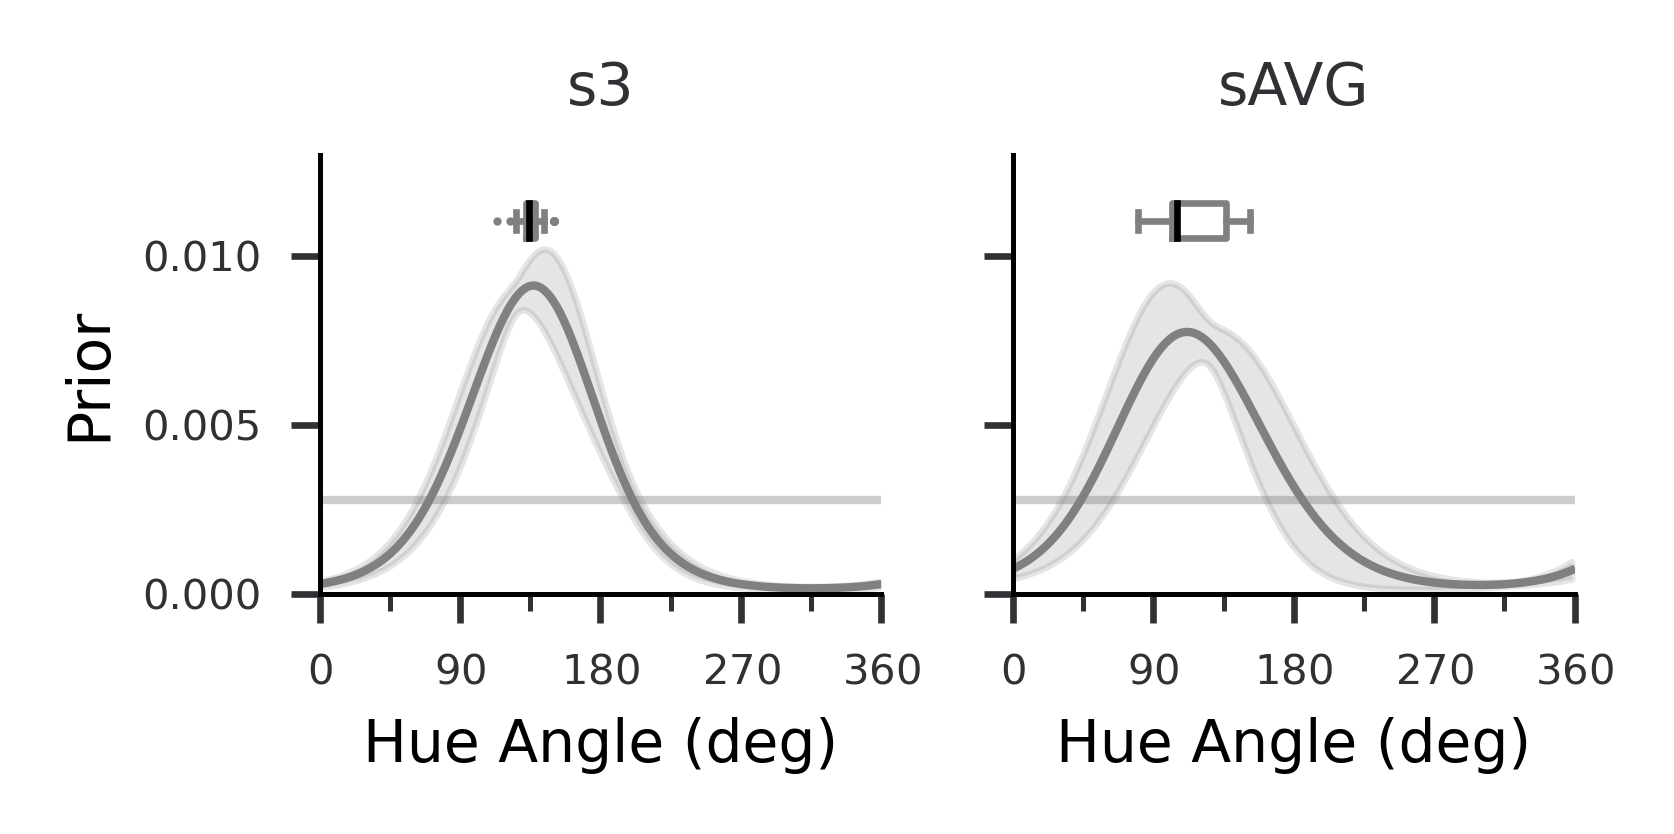

In [129]:
priors_subplots([sel_sub, 'sAVG'], btrp_priors, ylim=0.013, fig_name='Fig_3_v3') 
# priors_subplots([sel_sub, 'sAVG'], btrp_priors, ylim=0.013, fig_name=None) 

In [ ]:
# plot non-boostrapping prior on the top of boostrapping priors

# priors_without_btrp = pd.read_csv(f"{model_path}/gauss_prior.csv")
# priors_subplots([sel_sub, 'sAVG'], btrp_priors, priors_without_btrp=priors_without_btrp, fig_name=None, ylim=0.012)

## SFig 5
SFigure 5. Estimated prior for the representative subjects S1, S2, S3, S4, and S6 (five columns, respectively). The gray error band shows $\pm 1$ standard deviation of 1000 bootstrapped estimates. The light gray line represents the uniform prior. 

/tmp/ipykernel_1046421/4111977996.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_priors['Prior'] = sub_priors['Prior']/2.
/tmp/ipykernel_1046421/4111977996.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_priors['i_btrp'] = np.tile(np.repeat(np.arange(1, 101, 1), len(x_grid)), n_sub)


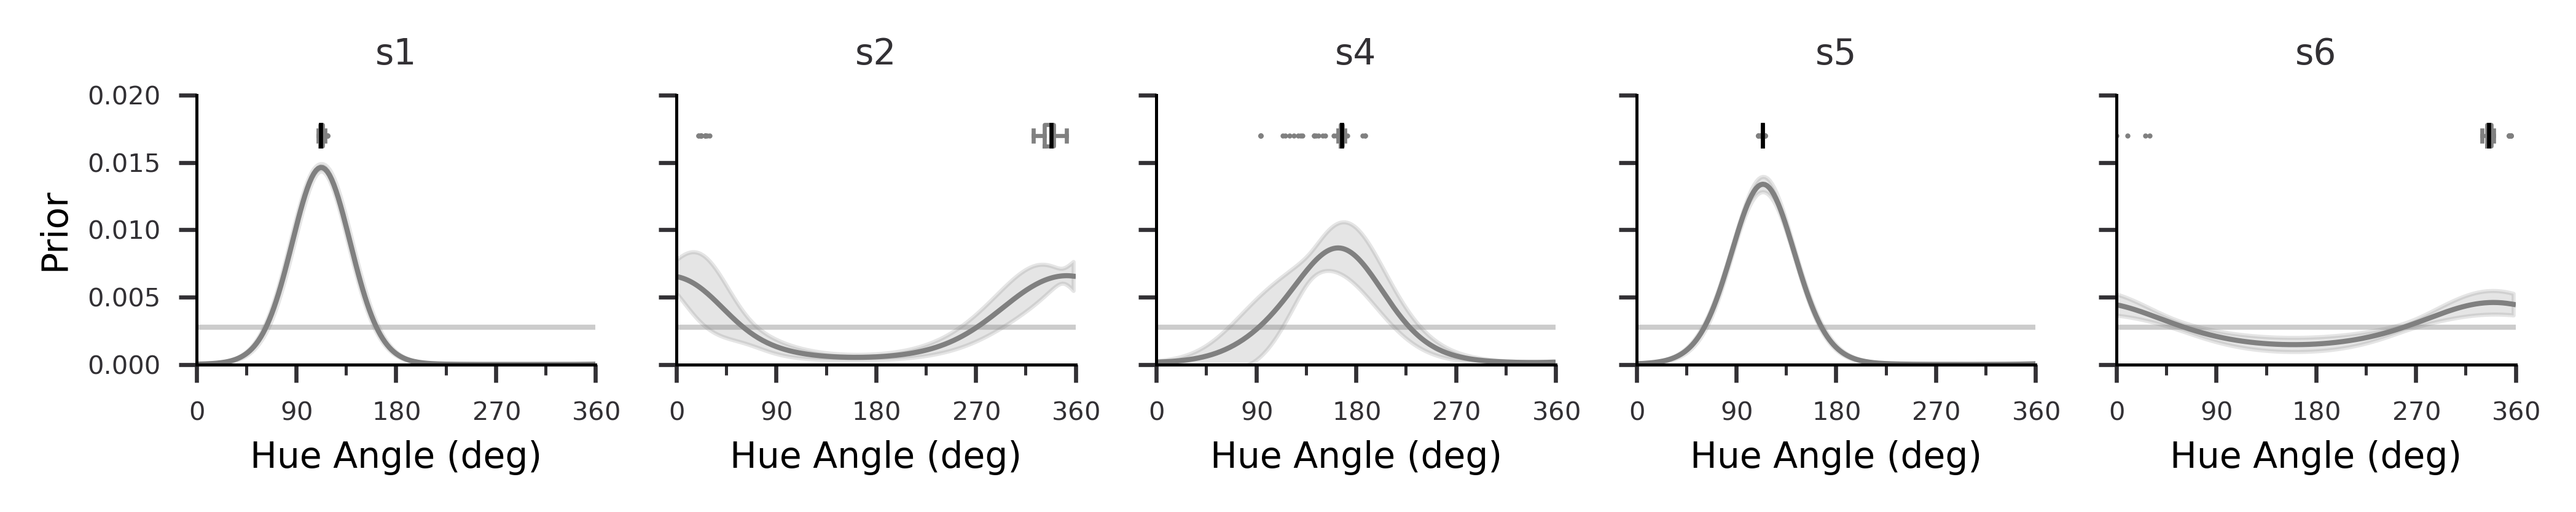

In [132]:
# priors_subplots(['s1', 's2', 's4', 's5', 's6'], btrp_priors, fig_name='SFig_3_v2', ylim=0.02)
priors_subplots(['s1', 's2', 's4', 's5', 's6'], btrp_priors, fig_name='SFig_3_v3', ylim=0.02)

# Results 4

In [5]:
def simul_mean_prior_subplots(model_path, estimates, fig_name=None):

    all_lh_data = pd.read_csv('data/all_sel_data.csv').query('condition == "LH"')

    mean_btrp_priors = pd.read_csv(f"{model_path}/gauss_prior_btrp100_mean.csv")
    # mean_btrp_priors = pd.read_csv(f"{model_path}/sine_prior.csv")

    flat_prior = prior_uniform()

    stims = estimates['Hue Angle'].unique()
    subs = estimates.subject.unique()
    n_sub = len(subs)

    if n_sub == 2:
        # subplot_width, subplot_height = 1.5, 1.5   # for single plot Fig4
        subplot_width, subplot_height = 2.0, 2.0     # for combined plot Fig4+5

    else:
         subplot_width, subplot_height = 1.4, 1.4

    # 1 row x n_sub columns 
    if n_sub == 2:
        fig, ax = plt.subplots(figsize=(subplot_width * n_sub, subplot_height), nrows=1, ncols=n_sub, sharex='none', sharey='none')
    else:
        fig, ax = plt.subplots(figsize=(subplot_width * n_sub, subplot_height), nrows=1, ncols=n_sub, sharex='none', sharey='row')
    for i_sub, sub in enumerate(subs):
        
        if sub == 'sAVG':
            lh_data = all_lh_data
        else:
            sub_in_data = sub[0] + '0' + sub[1]
            lh_data = all_lh_data.query("subject == @sub_in_data")
        
        sub_prior = mean_btrp_priors.query("sub == @sub")['Prior'].values
        sub_path = f"{model_path}/{sub}/{sub}"
        lik_l, lik_h = np.load(sub_path + "_likelihoods_l.npy"), np.load(sub_path + "_likelihoods_h.npy")
        
        sub_estimate = estimates.query("subject == @sub and condition == 'LH'")

        simul_res_flat, simul_fit_flat = simul_estimate(lh_data, flat_prior, [lik_l, lik_h])
        # loglik_flat = np.sum(each_loglik(lh_data, simul_res_flat, simul_fit_flat))

        simul_res_sub, simul_fit_sub = simul_estimate(lh_data, sub_prior, [lik_l, lik_h])
        # loglik_sub = np.sum(each_loglik(lh_data, simul_res_sub, simul_fit_sub))

        ax[i_sub].set_title(sub)
        ax[i_sub].scatter(stims, sub_estimate['PSE'], marker=cond_cfg['markers']['LH'], s=marker_size,linewidth=marker_linewidth, edgecolors='black', facecolors='none', label='true',  zorder=2)  
        ax[i_sub].errorbar(stims, sub_estimate['PSE'], sub_estimate['PSE_err'], ls='none', linewidth=marker_linewidth, capsize=0, color='black',  zorder=2)

        ax[i_sub].plot(stims, [-f.params[0] for f in simul_fit_flat.values] ,color=(0.8, 0.8, 0.8), label='uniform', zorder=0)
        ax[i_sub].plot(stims, [-f.params[0] for f in simul_fit_sub.values], color=(0.4, 0.4, 0.4), label='estimated',  zorder=1)

        ax[i_sub].set_xlim([0, 360])
        ax[i_sub].xaxis.set_minor_locator(plt.FixedLocator(x_minor_ticks))
        ax[i_sub].xaxis.set_major_locator(plt.FixedLocator(x_major_ticks))
        
        ax[i_sub].set_ylim([-12, 12])
        ax[i_sub].set_yticks([-10, -5, 0, 5, 10])
        ax[i_sub].set_xlabel('Hue Angle (deg)')
        if n_sub == 2:
            ax[i_sub].set_ylabel('PSE (deg), cross-noise')
        else:
            ax[0].set_ylabel('PSE (deg), cross-noise')

        if i_sub == 0:
            if n_sub == 2:
                leg = ax[i_sub].legend(loc=[0.05, 0.8], frameon=False)
            else:
                leg = ax[i_sub].legend(loc=[0.75, 0.8], frameon=False)

       
    plt.tight_layout() 
    plt.show()
    
    if fig_name is not None:
        fig.savefig(fig_dir + fig_name +".pdf", bbox_inches='tight', dpi=600)


## Fig 5 a-b
Figure 5. Relative bias with the prediction using the estimated and uniform priors for the represenative subject S5 (left) and the average subject (right). The circles represent the relative bias that is from Fig. 1.

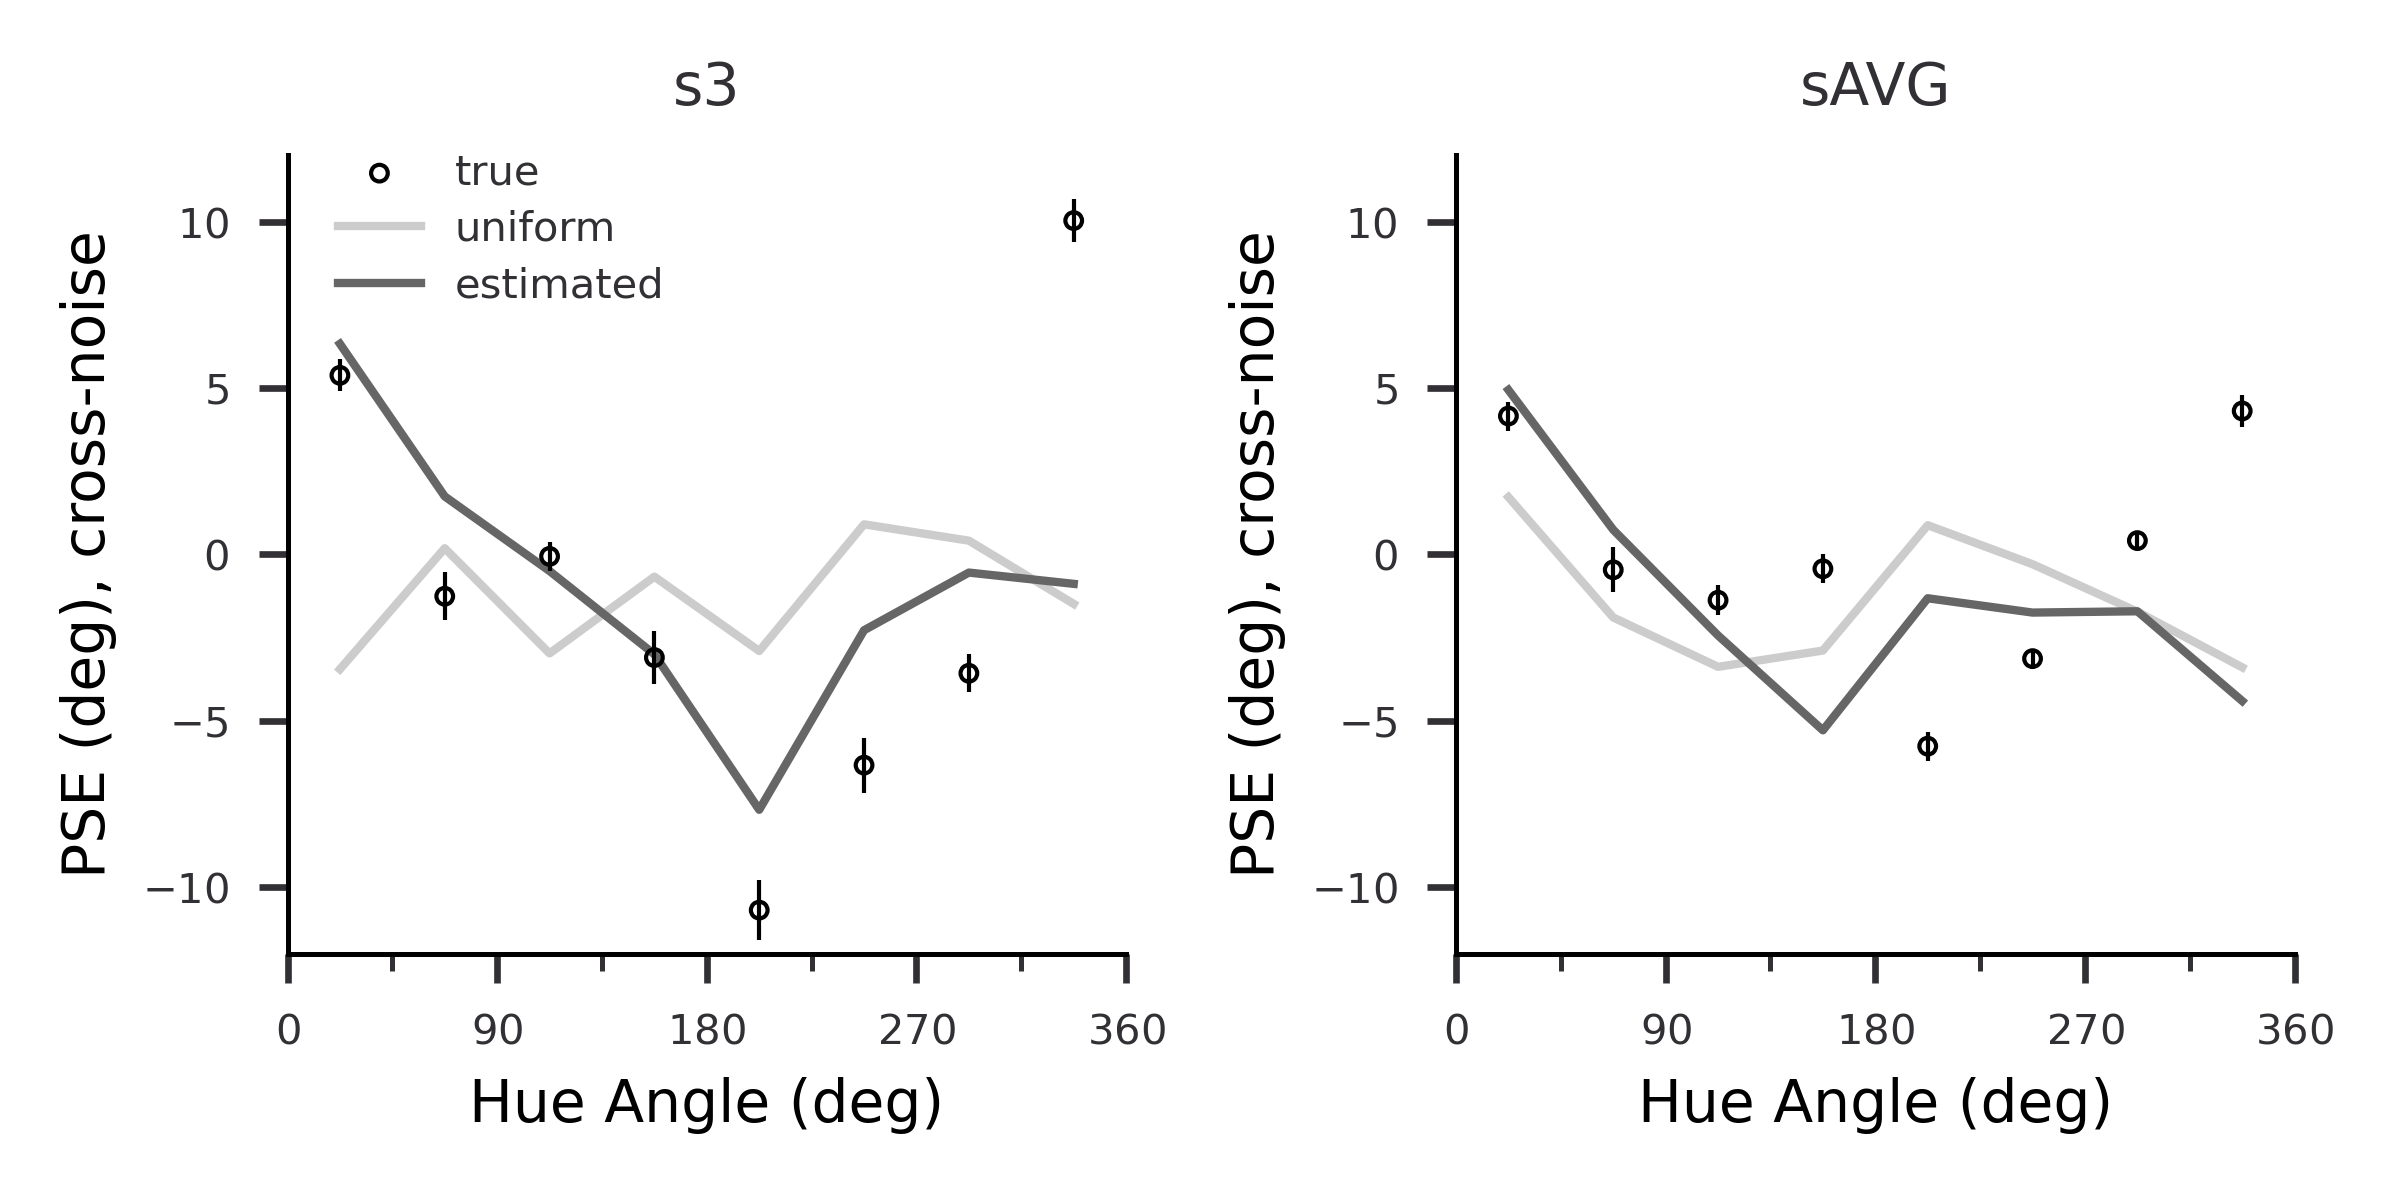

In [174]:
# simul_mean_prior_subplots(pd.concat([all_pf_estm.query("subject == @sel_sub"), sAVG_pf_estm]), fig_name='Fig_4')
# simul_mean_prior_subplots(pd.concat([all_pf_estm.query("subject == @sel_sub"), sAVG_pf_estm]), fig_name='Fig_4+5_4')
simul_mean_prior_subplots(model_path, pd.concat([all_pf_estm.query("subject == @sel_sub"), sAVG_pf_estm]), fig_name='Fig_4+5_4_v2')
# simul_mean_prior_subplots(model_path, pd.concat([all_pf_estm.query("subject == @sel_sub"), sAVG_pf_estm]), fig_name=None)



## SFig 6
Supplementary Figure 6. Relative bias with the prediction using the estimated and uniform priors for subjects S1, S2, S3, S4, and S6 (5 columns, respectively). The circles represent the relative bias that is from Fig. 1.

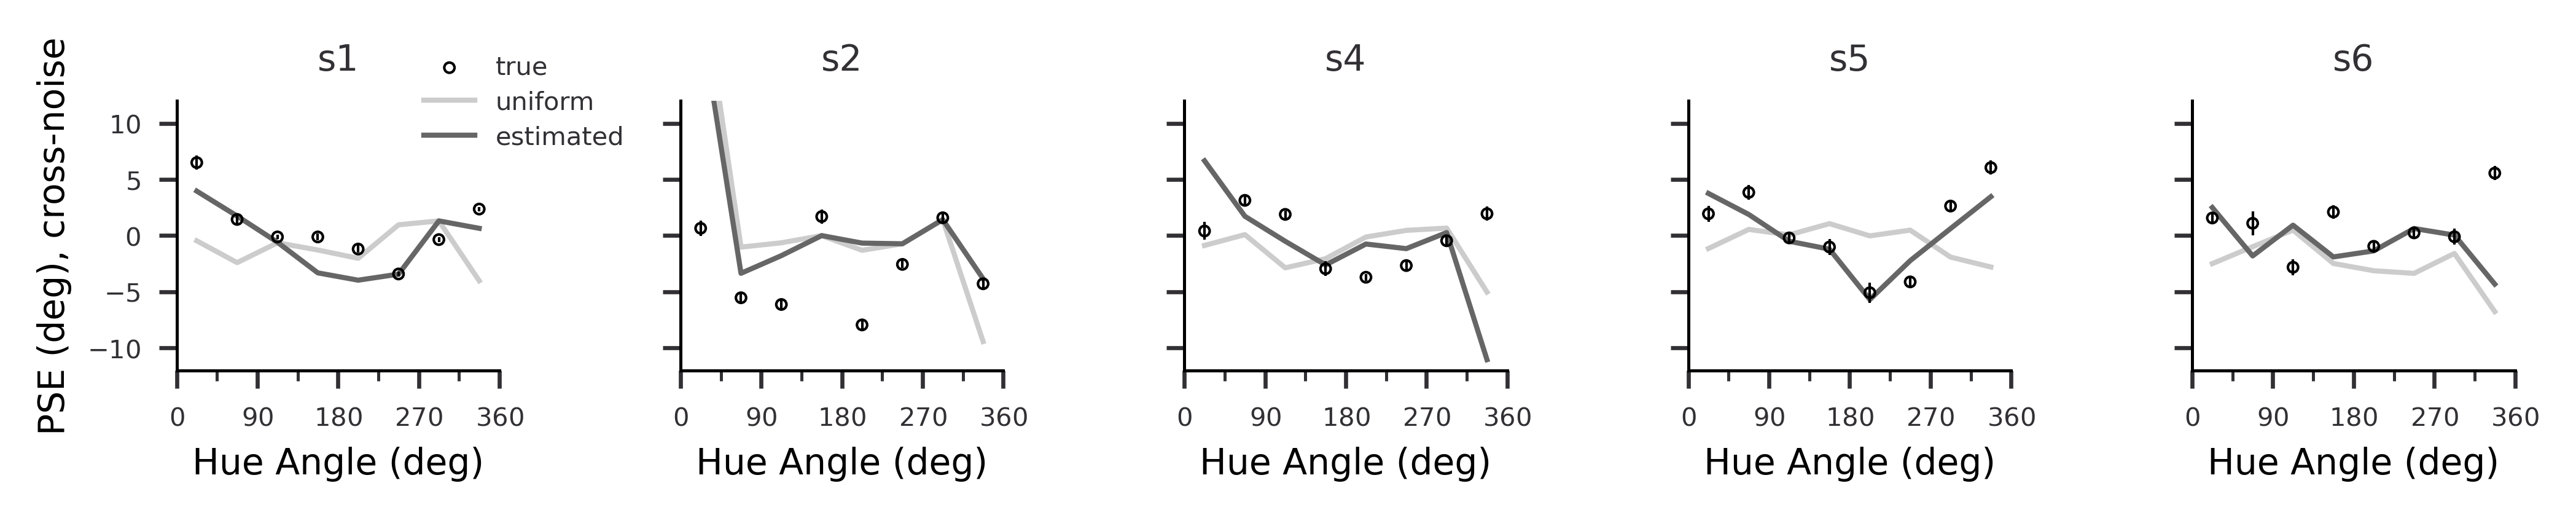

In [6]:

simul_mean_prior_subplots(model_path, all_pf_estm.query("subject != @sel_sub"), fig_name='SFig_4_v2')


# Results 5



There are several versions. The final version in the manuscript is the version 3.

Version 1:
Log likelihoods of predictions using the estimated and uniform priors for all subjects including the average subject (sAVG). Note that the log likelihoods are negative and the axis is inverted for better visulization. Thus, the shorter the bar, the better the prediction. 

Version 2:
Scaled log likelihoods of predictions using the estimated and uniform priors for all subjects including the average subject (sAVG). The values are scaled to raw psychometric fits. Values less than 0 indicate prediction worse than raw psychometric fits. Note that the axis is inverted for better visulization. Thus, the shorter the bar, the better the prediction. 


Version 3 (final version):
Normalized log likelihoods of predictions using the estimated prior for all subjects including the average subject (sAVG). Values greater than 1 indicate prediciton better than raw psychometric fits, and values greater than 0 indicate predition better than the model with uniform priors.

Version 4:
Similar to Version 1, but plot AIC instead of log likelihoods.


In [56]:
from data_analysis.fit_curves import FitCumNormal

def eval_mean_prior_subplots(model_path, estimates, priors, present_version=4, fig_name=None):

    all_lh_data = pd.read_csv('data/all_sel_data.csv').query('condition == "LH"')
    flat_prior = prior_uniform()

    # stims = estimates['Hue Angle'].unique()
    subs = estimates.subject.unique()
    # n_sub = len(subs)

    df_list = []
    for sub in subs:
        
        if sub == 'sAVG':
            lh_data = all_lh_data
        else:
            sub_in_data = sub[0] + '0' + sub[1]
            lh_data = all_lh_data.query("subject == @sub_in_data and condition == 'LH'")
        
        sub_prior = priors.query("sub == @sub")['Prior'].values
        sub_path = f"{model_path}/{sub}/{sub}"
        lik_l, lik_h = np.load(sub_path + "_likelihoods_l.npy"), np.load(sub_path + "_likelihoods_h.npy")
        
        # psychometric fit and simulate of raw data 
        simul_fit_raw = lh_data.groupby('standard_stim').apply(lambda x: FitCumNormal(x['actual_intensity'], x['resp_as_larger'], guess=[0, 5], expectedMin=0.0, lapse=0.0))
        loglik_raw = np.sum(each_loglik(lh_data, simul_fit_raw))
        
        # simulate and fit with flat prior
        simul_res_flat, simul_fit_flat = simul_estimate(lh_data, flat_prior, [lik_l, lik_h])
        # log scale
        # loglik_flat = np.sum(each_loglik(lh_data, simul_res_flat, simul_fit_flat))
        loglik_flat = np.sum(each_loglik(lh_data, simul_fit_flat))
        # linear scale
        # loglik_flat = np.sum(np.exp(each_loglik(lh_data, simul_res_flat, simul_fit_flat)))

        # simulate and fit with model prior
        simul_res_sub, simul_fit_sub = simul_estimate(lh_data, sub_prior, [lik_l, lik_h])
        # log scale
        # loglik_sub  = np.sum(each_loglik(lh_data, simul_res_sub, simul_fit_sub))
        loglik_sub  = np.sum(each_loglik(lh_data, simul_fit_sub))
        # linear scale
        # loglik_sub  = np.sum(np.exp(each_loglik(lh_data, simul_res_sub, simul_fit_sub)))

        if sub == 'sAVG':
            # loglik_flat, loglik_sub = loglik_flat/6., loglik_sub/6.
            loglik_raw, loglik_flat, loglik_sub = loglik_raw/6., loglik_flat/6., loglik_sub/6.
        
        if present_version == 1:
            # version 1:
            sub_df = pd.DataFrame([{'sub': sub, 'loglik_sub': loglik_sub, 'loglik_flat': loglik_flat}])
        elif present_version == 2:
            # version 2: normalize based on psychometrc raw fits = how much worse compared to the raw fit
            sub_df = pd.DataFrame([{'sub': sub, 'loglik_sub': (loglik_raw-loglik_sub)/loglik_raw, 'loglik_flat': (loglik_raw-loglik_flat)/loglik_raw}])
        elif present_version == 3:
            # version 3: normalize between psychometric raw fit(=1) and flat prior fit(=0)
            sub_df = pd.DataFrame([{'sub': sub, 'loglik_sub': (loglik_sub-loglik_flat)/(loglik_raw-loglik_flat)}])
        elif present_version == 4:
            # version 4: compute AIC and compare model and flat prior
            # AIC = 2k - 2ln(L)
            k_model = 2
            k_flat = 0
            sub_df = pd.DataFrame([{'sub': sub, 'AIC_sub': 2*k_model - 2*loglik_sub, 'AIC_flat': 2*k_flat - 2*loglik_flat}])
            # sub_df = pd.DataFrame([{'sub': sub, 'AIC_delta': (2*k_flat - 2*loglik_flat) - (2*k_model - 2*loglik_sub)}])
            # round to 3 decimal places
            sub_df = sub_df.round(3)
        else:
            raise ValueError("Wrong type for presentation style version")
        df_list.append(sub_df)

    liks = pd.concat(df_list)
    if present_version == 1:
        liks.to_csv(f"{model_path}/model_loglik.csv", index=False)
    if present_version == 3:
        liks.to_csv(f"{model_path}/model_normed_loglik.csv", index=False)
    if present_version == 4:
        liks.to_csv(f"{model_path}/models_AIC.csv", index=False)
    

    subplot_width, subplot_height = 2.5, 2.5  # for single plot Fig5
    # subplot_width, subplot_height = 2.0, 2.0   # for combined plot Fig4+5
    # subplot_width, subplot_height = 1.3, 1.3   # for combined plot SFig5

    # 1 row x 1 columns 
    fig, ax = plt.subplots(figsize=(subplot_width, subplot_height), nrows=1, ncols=1, sharex='none', sharey='none')

    if present_version == 1:
        # Version 1
        liks.plot(ax=ax, x='sub', kind='bar', color=((.4, .4, .4), (.8, .8, .8)), width=0.8, linewidth=0.)
        ax.set_ylim(-1000, -1550)
        ax.set_yticks([-1100, -1300, -1500])
        ax.set_ylabel('Log likelihood')
        leg = ax.legend(["estimated", "uniform"], loc=(0.85, 0.85), frameon=False)

    elif present_version == 2:
        # Version 2
        liks.plot(ax=ax, x='sub', kind='bar', color=((.4, .4, .4), (.8, .8, .8)), width=0.8, linewidth=0.)
        ax.set_ylabel('Scaled log likelihood')
        ax.set_ylim(-0.05, -0.5)
        ax.set_yticks([0, -0.1, -0.2, -0.3, -0.4])
        leg = ax.legend(["estimated", "uniform"], loc=(0.85, 0.85), frameon=False)

    elif present_version == 3:
        # Version 3
        ax.axhline(y=1.0, linestyle='--', color=(.8, .8, .8), zorder=0)
        ax.axhline(y=0.0, linestyle='--', color=(.8, .8, .8), zorder=0)
        liks.plot(ax=ax, x='sub', kind='bar', color=(.4, .4, .4), width=0.8, linewidth=0. )
        # ax.set_ylabel('Normalized log likelihood')
        ax.set_ylabel('Normalized \n log likelihood')
        ax.set_ylim(-0.01, 1.01)
        ax.set_yticks([0, .2, .4, .6, .8, 1.])
        ax.get_legend().remove()
        # leg = ax.legend(loc=(0.85, 0.85), frameon=False)

    elif present_version == 4:
        # Version 4
        liks.plot(ax=ax, x='sub', kind='bar', color=((.4, .4, .4), (.8, .8, .8)), width=0.8, linewidth=0. )
        # show text on top of bars as AIC values with 2 decimal places
        for p in ax.patches:
            ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=4, color='black', xytext=(0, 5),
                        textcoords='offset points')
        ax.set_ylabel('AIC')
        ax.set_ylim(2000, 3200)
        # ax.set_yticks([0, 50, 100])
        leg = ax.legend(["estimated", "uniform"], loc=(0.85, 0.85), frameon=False)

    else:
        raise ValueError("Wrong type for presentation style version")

    # plt.xticks(rotation=0)
    ax.set_xlabel('Subject')
    plt.tight_layout() 
    plt.show()

    if fig_name is not None:
        fig.savefig(fig_dir + fig_name +".pdf", bbox_inches='tight', dpi=600)

In [ ]:
# eval_mean_prior_subplots(model_path, pd.concat([all_pf_estm, sAVG_pf_estm]), mbtrp_priors, present_version=1, fig_name='Fig_4+5_5_v2_lik')
# eval_mean_prior_subplots(model_path, pd.concat([all_pf_estm, sAVG_pf_estm]), mbtrp_priors, present_version=4, fig_name='Fig_4+5_5_v2_AIC')


## Fig 5c

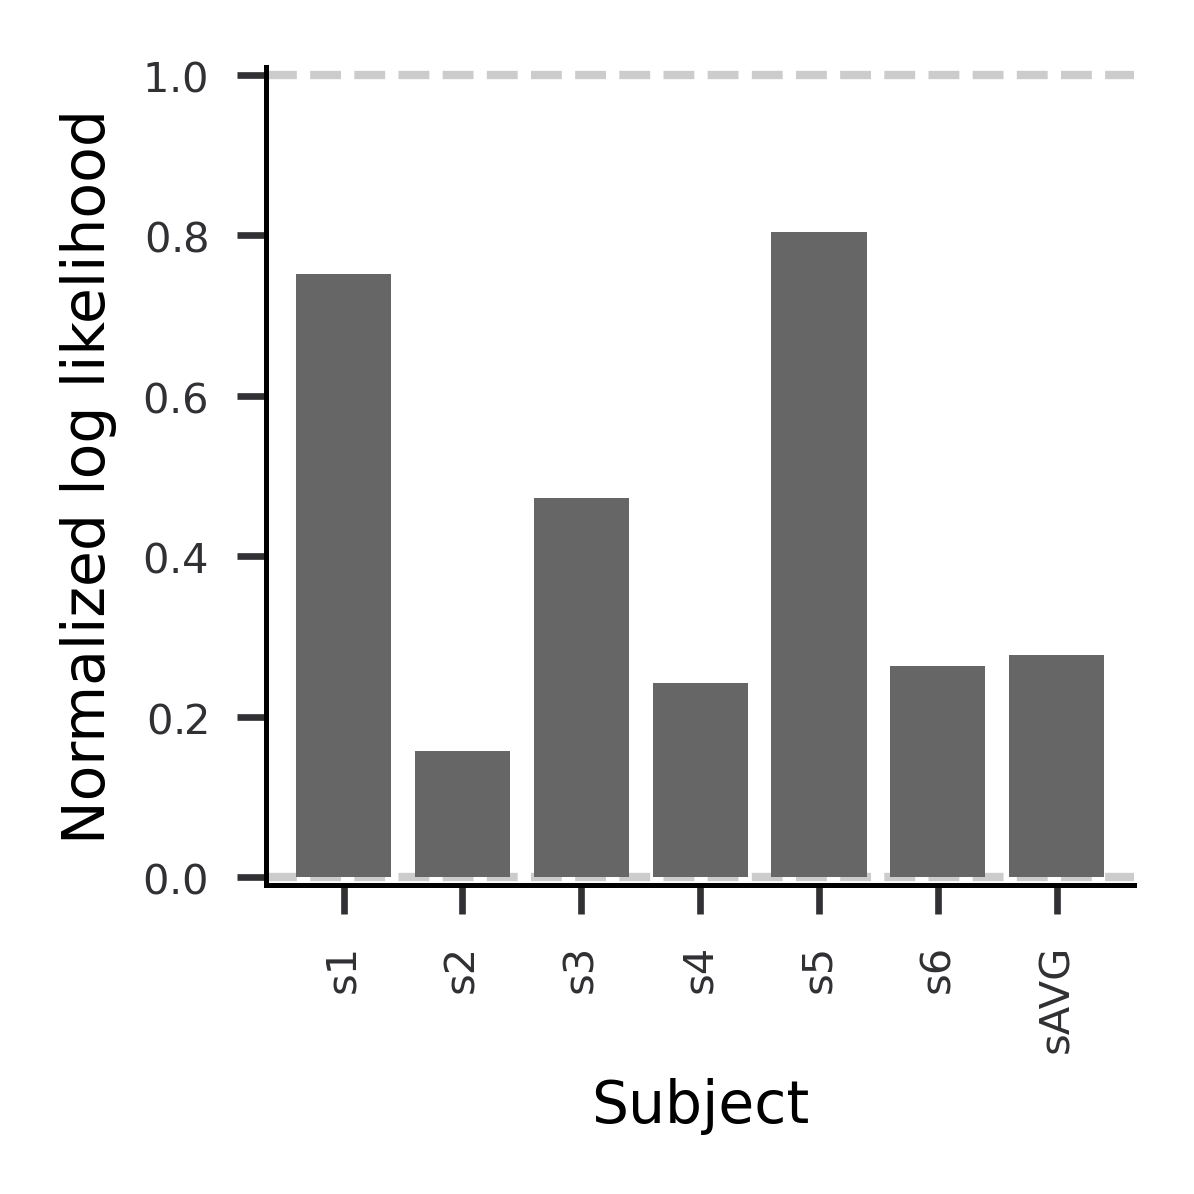

In [181]:
# eval_mean_prior_subplots(pd.concat([all_pf_estm, sAVG_pf_estm]), mbtrp_priors, fig_name="Fig_5")
# eval_mean_prior_subplots(pd.concat([all_pf_estm, sAVG_pf_estm]), mbtrp_priors, fig_name="Fig_4+5_5_v2")
# eval_mean_prior_subplots(model_path, pd.concat([all_pf_estm, sAVG_pf_estm]), mbtrp_priors, fig_name="Fig_4+5_5_v3")

eval_mean_prior_subplots(model_path, pd.concat([all_pf_estm, sAVG_pf_estm]), mbtrp_priors, fig_name="Fig_4+5_5_v3_v2")
# eval_mean_prior_subplots(model_path, pd.concat([all_pf_estm, sAVG_pf_estm]), mbtrp_priors, present_version=3, fig_name=None)


## SFig 7
Supplementry Figure 7. Estimated prior as a sine function of $\theta$. (A) Estimated sine-shaped priors for all subjects including the average subject (sAVG) (7 columns, respectively). The light gray line represents the uniform prior. (B) Log likelihoods of predictions using the estimated sine-shaped and uniform priors for all subjects including the average subject (sAVG). Note that the log likelihoods are negative and the axis is inverted for better visulization. Thus, the shorter the bar, the better the prediction. 

In [182]:
sine_priors = pd.read_csv(f"{model_path}/sine_prior.csv")
sine_2peak_priors = pd.read_csv(f"{model_path}/sine_2peak_prior.csv")

gauss_2peak_priors = pd.read_csv(f"{model_path}/gauss_2peak_prior.csv")


In [197]:
from scipy import stats
sine_priors_peakidx = sine_priors.groupby(['sub'])['Prior'].idxmax().reset_index()
# find the hue angle has the max value in each boostrap prior for each subject
sine_priors_peakloc = sine_priors.loc[sine_priors_peakidx.Prior.values, ['sub', 'Hue Angle']]

# convert hue angles to radian and do circular stats
sine_priors_peakloc['Hue Angle rad'] = sine_priors_peakloc['Hue Angle']/180. * np.pi
# f"{np.rad2deg(stats.circmean(sine_priors_peakloc['Hue Angle rad']))} +/- {np.rad2deg(stats.circstd(sine_priors_peakloc['Hue Angle rad']))}"
f"{np.rad2deg(stats.circmean(sine_priors_peakloc['Hue Angle rad']))} +/- {(np.rad2deg(stats.circstd(sine_priors_peakloc['Hue Angle rad'])))/np.sqrt(len(sine_priors_peakloc))}"


'119.06363673599058 +/- 28.624041119701683'

In [186]:
sine_2peak_priors_peakloc = sine_2peak_priors.groupby(['sub'])['Prior'].apply(lambda x: x_grid[find_peaks(x, distance=60)[0]])
sine_2peak_priors_peakloc


sub
s1       [58.0001, 238.0001]
s2      [164.0001, 344.0001]
s3       [34.0001, 214.0001]
s4        [2.0001, 182.0001]
s5       [24.0001, 204.0001]
s6       [38.0001, 218.0001]
sAVG    [162.0001, 342.0001]
Name: Prior, dtype: object

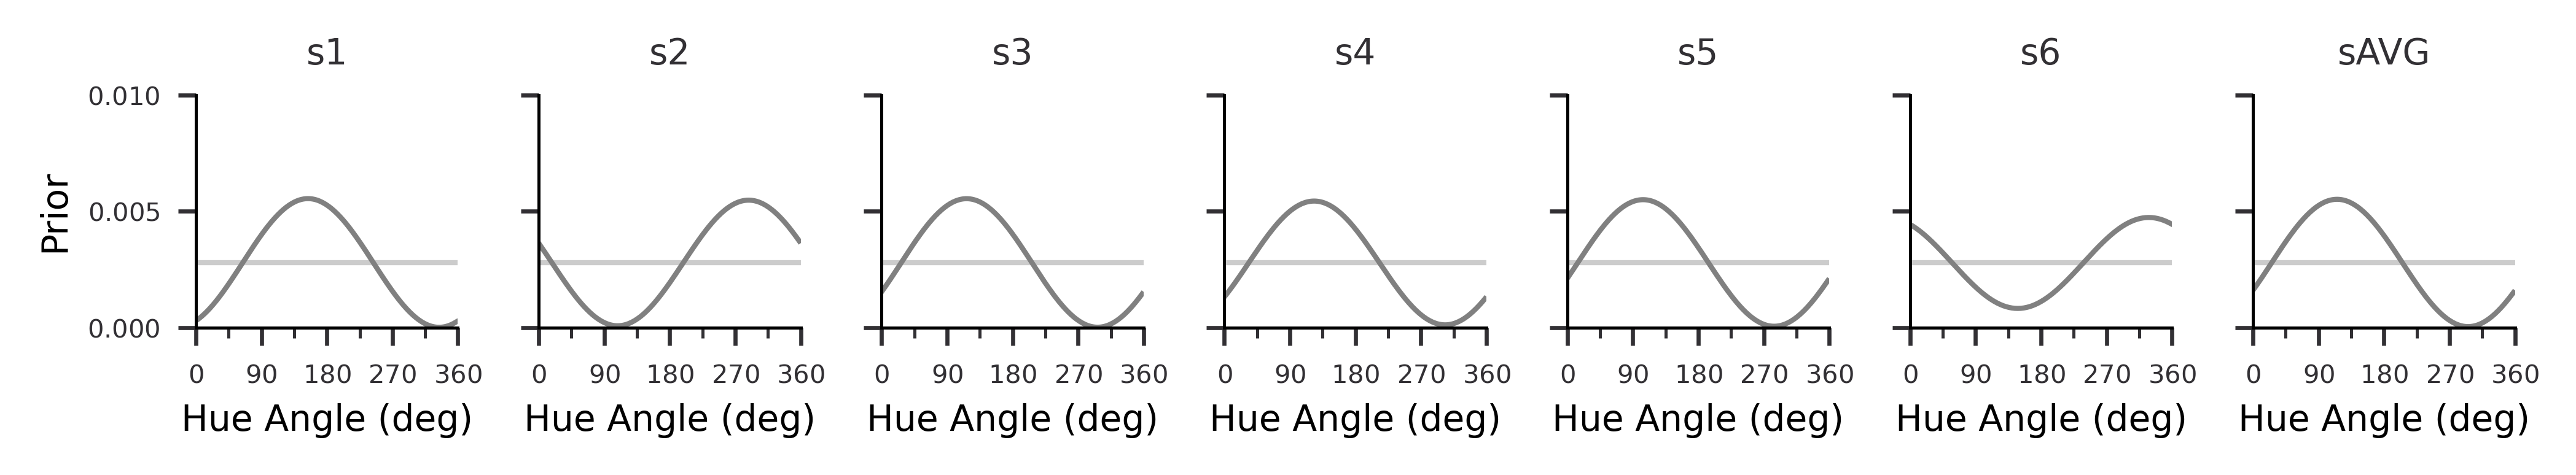

In [191]:
priors_subplots(['s1', 's2', 's3', 's4', 's5', 's6', 'sAVG'], sine_priors, fig_name="SFig_5A_v2", ylim=0.01)


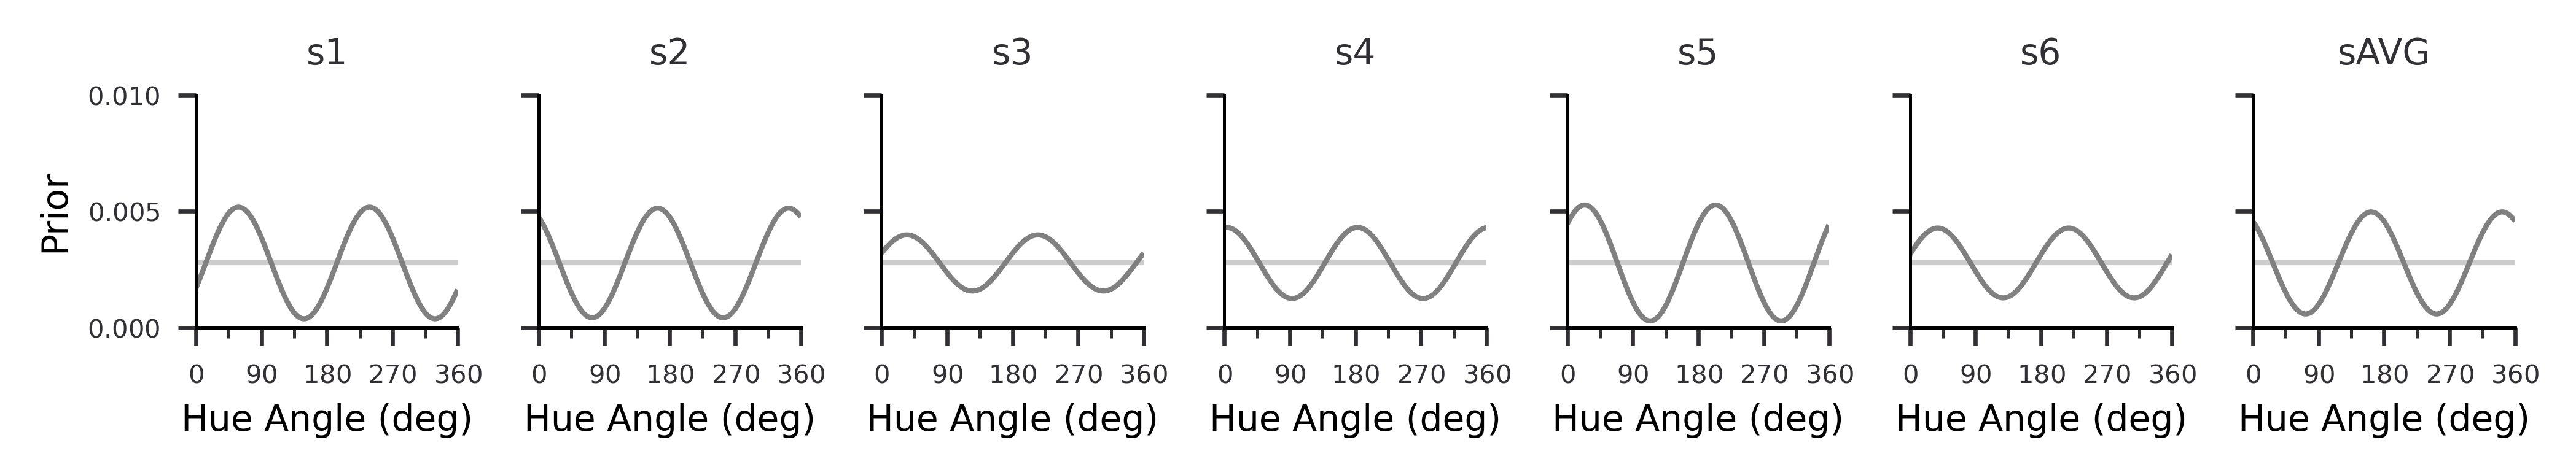

In [192]:
priors_subplots(['s1', 's2', 's3', 's4', 's5', 's6', 'sAVG'], sine_2peak_priors, fig_name="SFig_5A_v2_2peak", ylim=0.01)


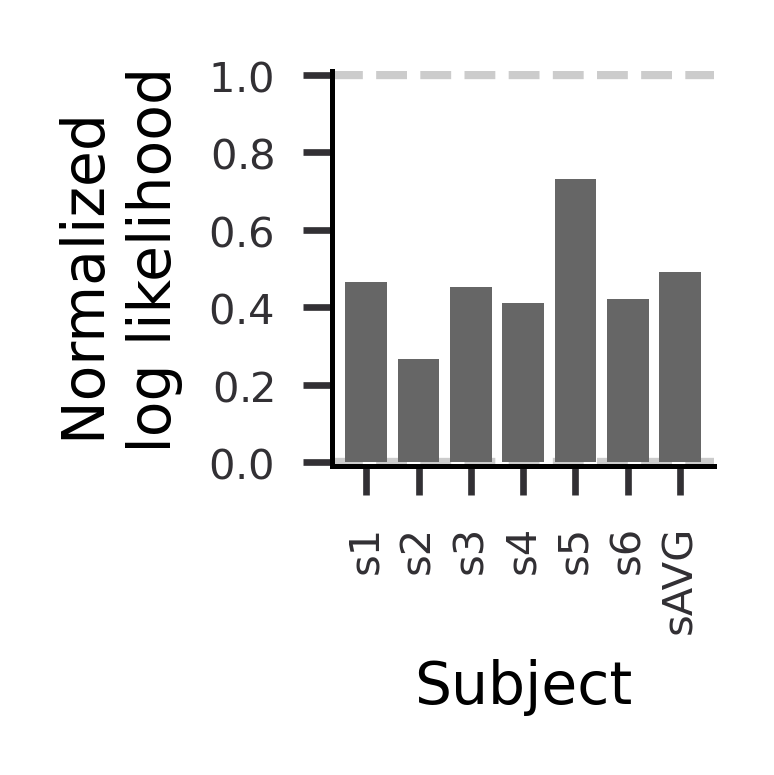

In [198]:
eval_mean_prior_subplots(model_path, pd.concat([all_pf_estm, sAVG_pf_estm]), sine_priors, fig_name="SFig_5B_v2")
# eval_mean_prior_subplots(model_path, pd.concat([all_pf_estm, sAVG_pf_estm]), sine_priors, fig_name=None)

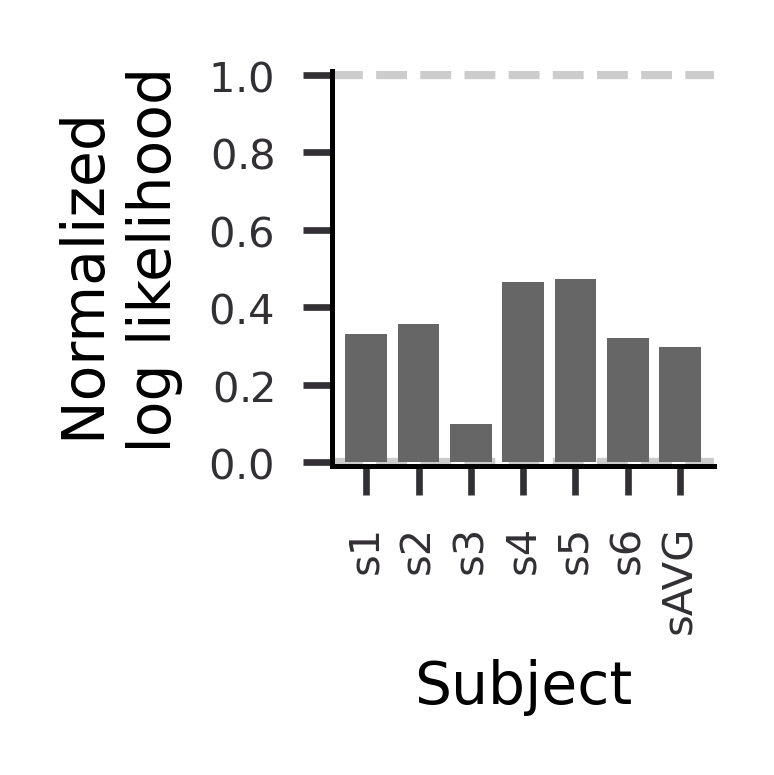

In [199]:
eval_mean_prior_subplots(model_path, pd.concat([all_pf_estm, sAVG_pf_estm]), sine_2peak_priors, present_version=3, fig_name="SFig_5B_v2_2peak")
# eval_mean_prior_subplots(model_path, pd.concat([all_pf_estm, sAVG_pf_estm]), sine_2peak_priors, present_version=3, fig_name=None)

# SFig 8

Predict PSE with a direct functional relation (Wei2017-mm) between perceptual bias and discrimination threshold in the form of 

$$
b(\theta) \propto (D(\theta)^2)'
$$

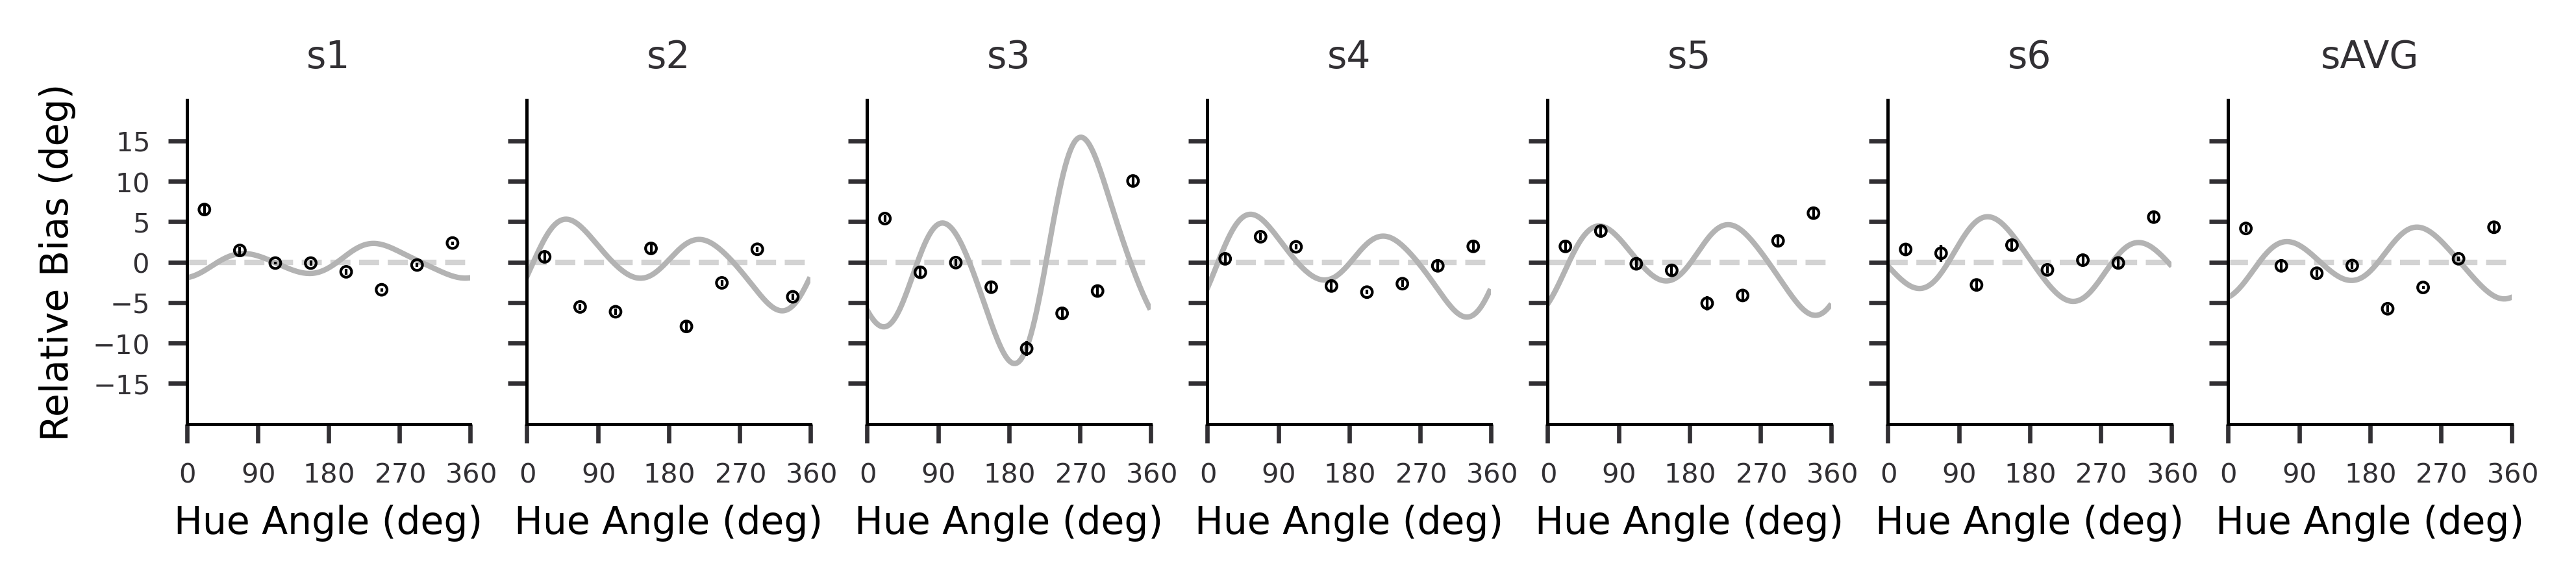

In [134]:
from scipy.misc import derivative


def mixed_sin_square(x, s1, s2, a, b):
    """
    Mixed sine function
    param x:       angle in degree
    param s1, s2:  shifts in degree
    param a:  amplitudes
    param b:  offsets
    """
    msin = a * (np.sin((x + s1) * np.pi / 90.0) + np.sin((x + s2) * np.pi / 180.0)) + b
    return msin**2

def mixed_sin_derivative(pars, x):
    return derivative(mixed_sin_square, x, dx=1/2/np.pi, args=pars)


pf_estm = pd.concat([all_pf_estm, sAVG_pf_estm], ignore_index=True)
subs = pf_estm.subject.unique()
n_sub = len(subs)

stims = pf_estm['Hue Angle'].unique()

subplot_width, subplot_height = 1.1, 1.1
fig, ax = plt.subplots(figsize=(subplot_width * n_sub, subplot_height), nrows=1, ncols=n_sub, sharey=True)

for idx, sub in enumerate(subs):
    pickle_l, pickle_h = f"{model_path}/{sub}/{sub}_jnd_fit_l.pickle", f"{model_path}/{sub}/{sub}_jnd_fit_h.pickle", 
    pickle_lh = f"{model_path}/{sub}/{sub}_jnd_fit_lh.pickle"

    with open(pickle_l, 'rb') as f:
        fit_jnd_l = pickle.load(f)
    with open(pickle_h, 'rb') as f:
        fit_jnd_h = pickle.load(f)
    with open(pickle_lh, 'rb') as f:
        fit_jnd_lh = pickle.load(f)

    # fit_jnd_l_pars.append(fit_jnd_l['params'])
    # fit_jnd_h_pars.append(fit_jnd_h['params'])
    # fit_jnd_lh_pars.append(fit_jnd_lh['params'])

    # fit_jnd_l_pars = np.array(fit_jnd_l_pars)
    # fit_jnd_h_pars = np.array(fit_jnd_h_pars)
    # fit_jnd_lh_pars = np.array(fit_jnd_lh_pars)

    bias_by_law = mixed_sin_derivative(fit_jnd_lh['params'], x=x_grid) 
    # bias_by_law = np.apply_along_axis(mixed_sin_derivative, 0, fit_jnd_lh['params'], x=x_grid) 
    # bias_by_law = np.apply_along_axis(mixed_sin_derivative, 1, fit_jnd_h_pars, x=x_grid)  - np.apply_along_axis(mixed_sin_derivative, 1, fit_jnd_l_pars, x=x_grid)

    bias_by_law = - bias_by_law * 8

    ax[idx].set_title(sub)
    ax[idx].plot(x_grid, bias_by_law, color=[.7, .7, .7])  
    ax[idx].scatter(stims, pf_estm.query("subject == @sub and condition=='LH'")['PSE'], 
                    marker=cond_cfg['markers']['LH'], s=marker_size,linewidth=marker_linewidth, edgecolors='black', facecolors='none', label='true',  zorder=2)  
    ax[idx].errorbar(stims, pf_estm.query("subject == @sub and condition=='LH'")['PSE'], 
                            yerr=pf_estm.query("subject == @sub and condition=='LH'")['PSE_err'], 
                            ls='none', linewidth=marker_linewidth, capsize=0, color='black',  zorder=2)
    ax[idx].set_xticks(np.arange(0, 360+45, 90))
    ax[idx].set_xlim([0, 360])
    ax[idx].set_ylim([-20, 20])
    ax[idx].axhline(0, ls='--', color='lightgray', zorder=1)
    ax[idx].set_xlabel('Hue Angle (deg)')
ax[0].set_ylabel('Relative Bias (deg)')
ax[0].set_yticks(np.arange(-15, 20, 5))
# plt.tight_layout()

fig.savefig(fig_dir + "SFig_7.pdf", bbox_inches='tight', dpi=600)

# SFig 9 (not used in the paper)

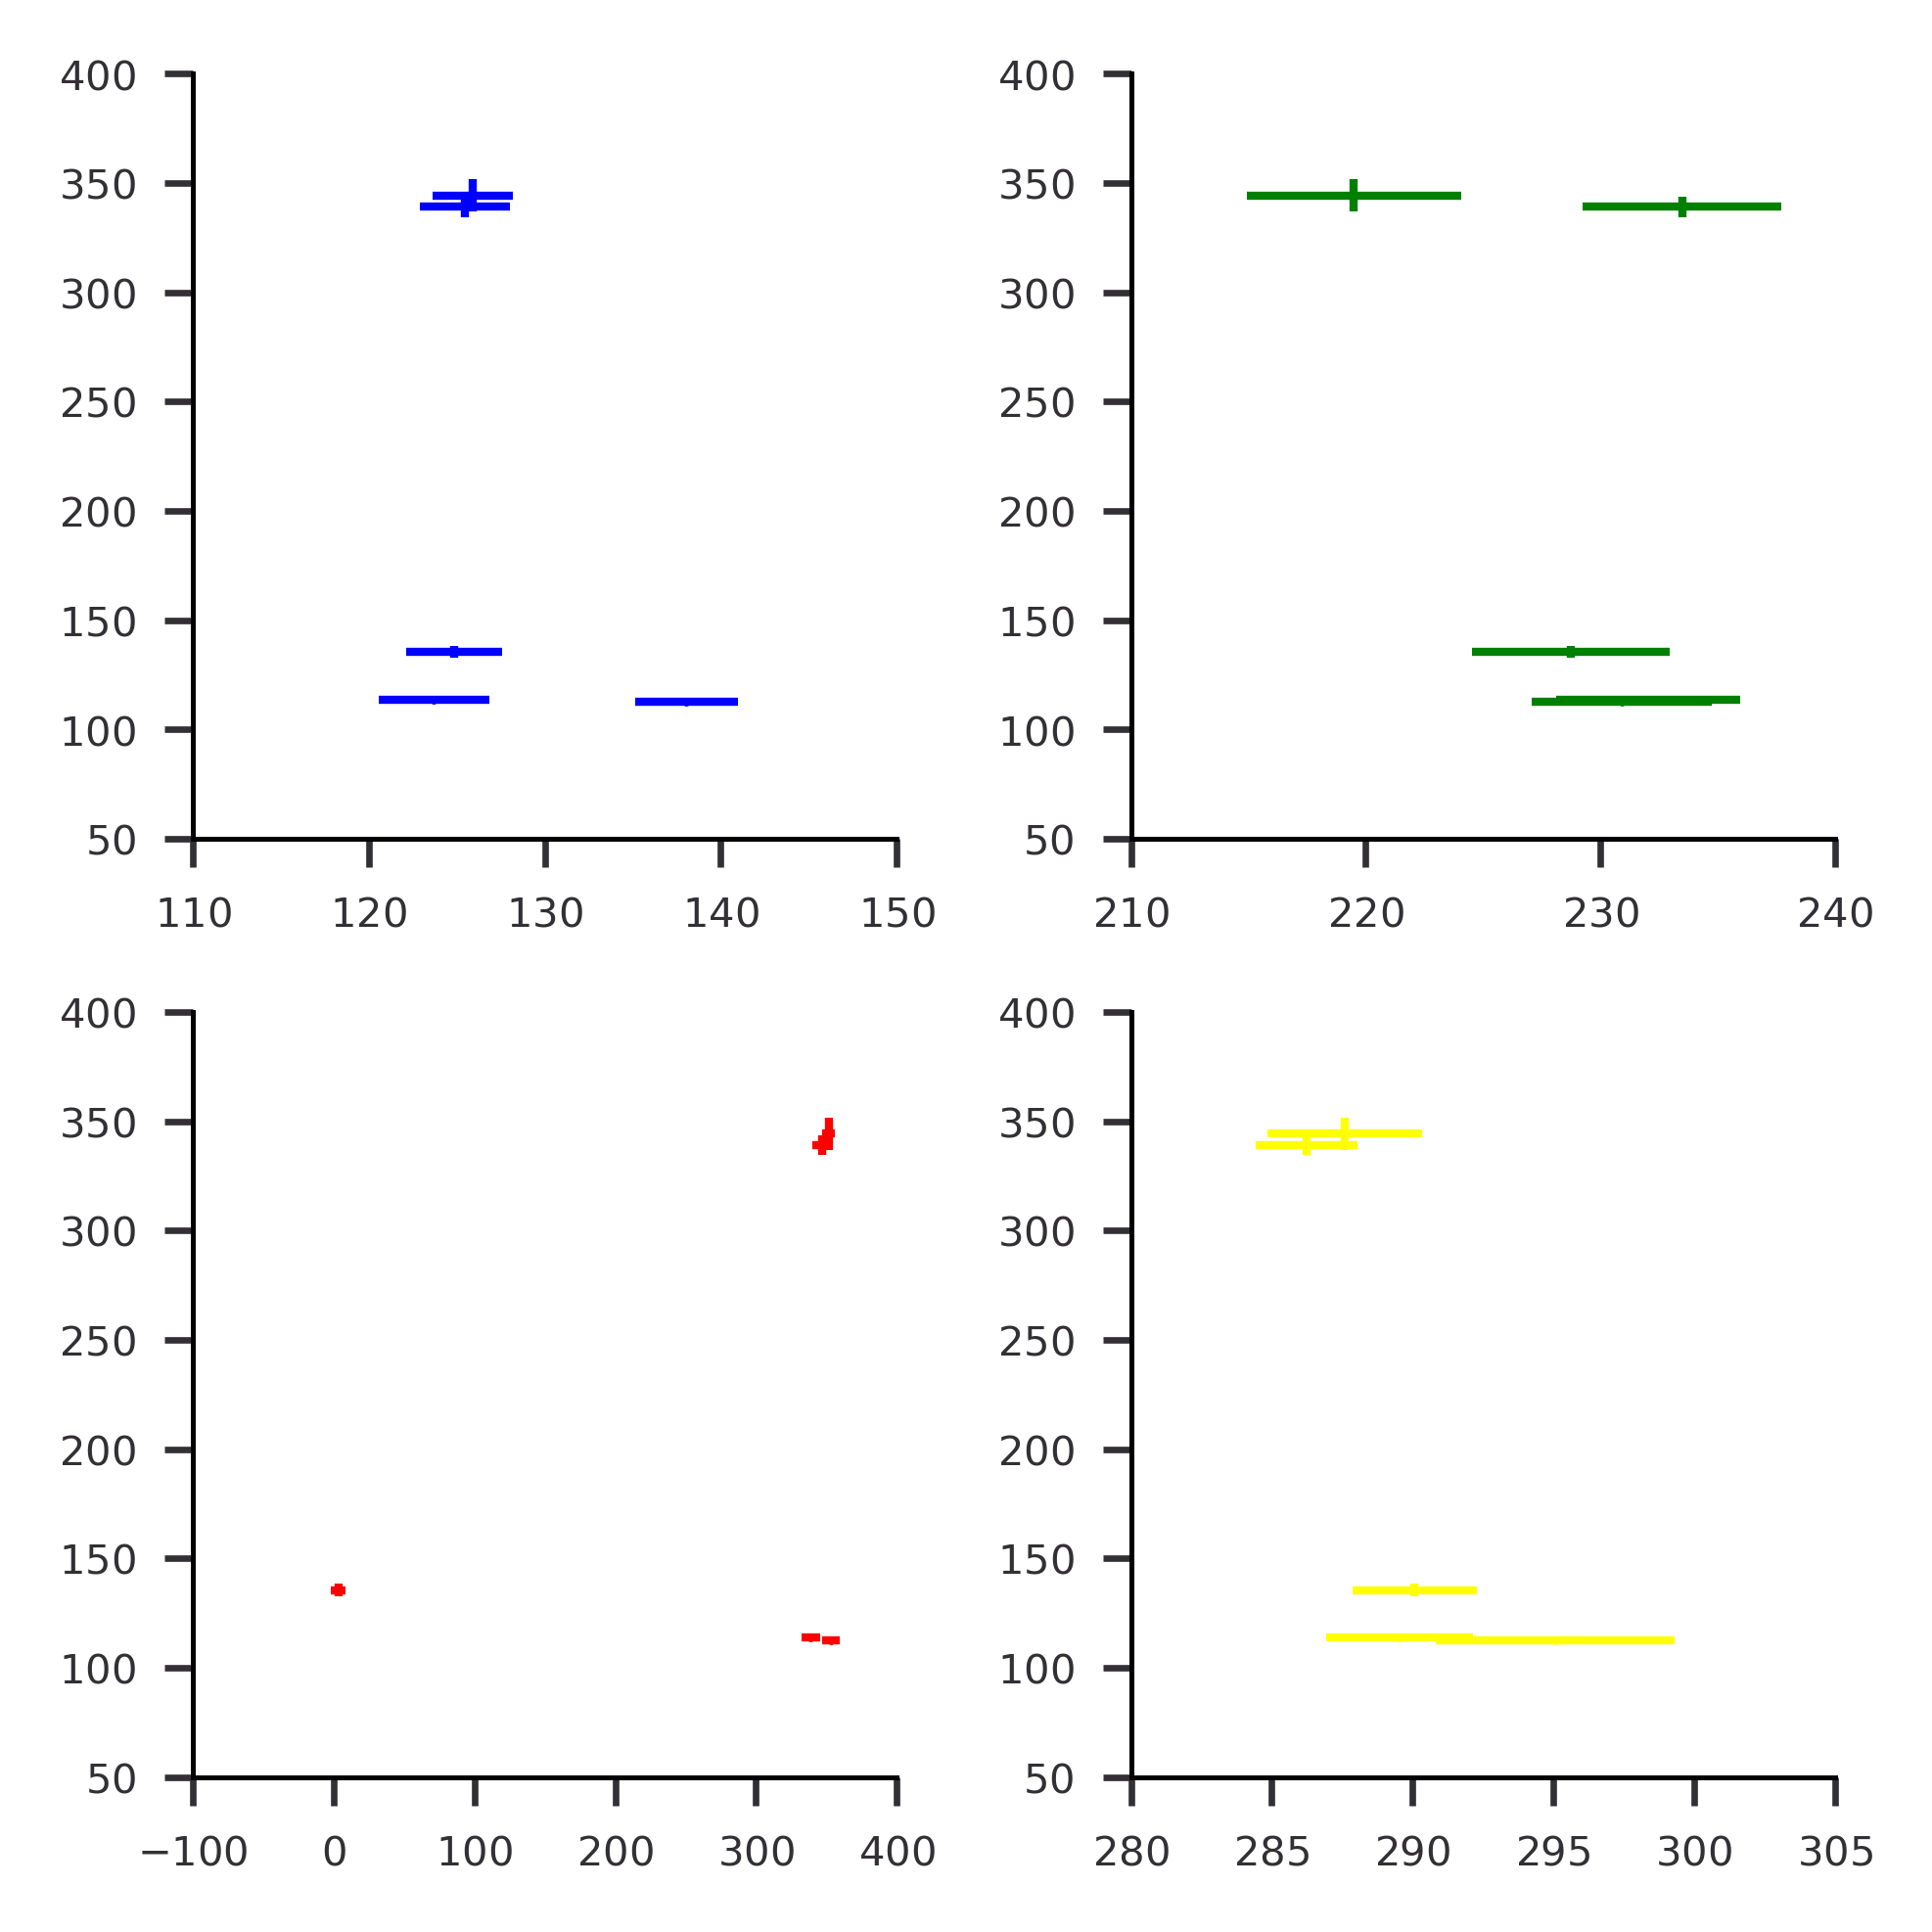

In [221]:
sel_subs = ['s01', 's02', 's03', 's05', 's06']
unique_hue_loc = pd.concat([pd.read_csv(f'data_analysis/unique_hues/{s}_unique_hues.csv') for s in sel_subs])

prior_peak_locs = pd.read_csv(f"{model_path}/gauss_prior_btrp100_peakloc.csv").query("sub !='sAVG'").query("sub !='s4'")

ppeak_mean = prior_peak_locs['Hue Angle mean'].values
ppeak_std = prior_peak_locs['Hue Angle std'].values


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(subplot_height*1.5*2, subplot_height*1.5*2))
for ax, h in zip(axes.flatten(), unique_hue_loc.unique_hue.unique()):
    uhue_mean = unique_hue_loc[unique_hue_loc.unique_hue==h]['circmean_deg'].values
    uhue_std = unique_hue_loc[unique_hue_loc.unique_hue==h]['circstd_deg'].values
    ax.errorbar(uhue_mean, ppeak_mean, 
                xerr=uhue_std/np.sqrt(len(sel_subs)),
                fmt='o',  ms=1, color=h, label='unique_hue')
    ax.errorbar(uhue_mean, ppeak_mean, 
                yerr=ppeak_std/np.sqrt(len(sel_subs)),
                fmt='o', ms=1, color=h)#, label='prior peak')
plt.tight_layout()

# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(subplot_height*1.5*2, subplot_height*1.5))
# for h in unique_hue_loc.unique_hue.unique():
#     uhue_mean = unique_hue_loc[unique_hue_loc.unique_hue==h]['circmean_deg'].values
#     uhue_std = unique_hue_loc[unique_hue_loc.unique_hue==h]['circstd_deg'].values
#     axes.errorbar(uhue_mean, ppeak_mean, 
#                 xerr=uhue_std/np.sqrt(len(sel_subs)),
#                 fmt='o', ms=1, label='unique_hue', color=h)
#     axes.errorbar(uhue_mean, ppeak_mean, 
#                 yerr=ppeak_std/np.sqrt(len(sel_subs)),
#                 fmt='o', ms=1, color=h)#, label='prior peak')
# plt.tight_layout()
# plt.xlim([-2, 362])
# plt.xticks(np.arange(0, 360+45,45))